# LOAN DEFAULT DETECTION

In this dataset I'll be working on predicting loan default. Data used for this dataset were taken from 3 sources on kaggle:

- Main dataset: https://www.kaggle.com/competitions/predict-loan-default/overview
- Cities population datasets: https://www.kaggle.com/datasets/meeratif/list-of-cities-in-china-by-population
- Indian states vise data: https://www.kaggle.com/datasets/gokulrajkmv/indian-statewise-data-from-rbi

Evaluation metric used for this project will be F1 for default. 

Data about states and ciies are taken from Indian census data which are actulalized every 10 years. Because of COVID-19 lastly published data is from 2011.

## 1. Importing necessary modules and libaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.pipeline import Pipeline
import warnings

In [2]:
warnings.simplefilter('ignore')

## 2. Data cleaning and EDA

### A. Indrotuctive analysis of main dataset

First we need to import main dataset.

In [3]:
df = pd.read_csv('train.csv', index_col='Id')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176400 entries, 153826 to 56784
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Income             176400 non-null  int64 
 1   Age                176400 non-null  int64 
 2   Experience         176400 non-null  int64 
 3   Married.Single     176400 non-null  object
 4   House_Ownership    176400 non-null  object
 5   Car_Ownership      176400 non-null  object
 6   Profession         176400 non-null  object
 7   CITY               176400 non-null  object
 8   STATE              176400 non-null  object
 9   CURRENT_JOB_YRS    176400 non-null  int64 
 10  CURRENT_HOUSE_YRS  176400 non-null  int64 
 11  Risk_Flag          176400 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 17.5+ MB


As we can see in all of the columns we don't have any null records. Data contains personal information about customers which have taken a loan. We have 6 numeric columns:

- Income - income of the person 
- Age - age of the person
- Experience - job experiance
- CURRENT_JOB_YRS - years in current job
- CURRENT_HOUSE_YRS - years lived in current house
- Risk_Flag - target column - loan default/not default (1 means default)

There are also 6 object-type columns:

- Married.Single - marital status
- House_Ownership - ownership of house
- Car_Ownrship - ofwnership of a car
- Profession - profession of person
- CITY - city of living
- STATE - state of living

Let's take a look for first rows of data and descriptive statistics:

In [5]:
df.head()

Income  Age  Experience Married.Single House_Ownership Car_Ownership  \
Id                                                                              
153826  2453544   47          10         single          rented            no   
54421   2192899   45          12         single          rented            no   
6621    6474294   48           9         single          rented            no   
103101   220528   72          18        married          rented            no   
216287  5786391   73           6        married          rented            no   

                   Profession       CITY           STATE  CURRENT_JOB_YRS  \
Id                                                                          
153826              Architect  Bharatpur       Rajasthan                5   
54421                 Drafter    Giridih       Jharkhand                6   
6621                 Comedian   Amritsar          Punjab                8   
103101  Technology_specialist      Hapur   Uttar_Pradesh                4   
216287         Microbiologist   Kakinada  Andhra_Pradesh                6   

        CURRENT_HOUSE_YRS  Risk_Flag  
Id                                    
153826                 14          0  
54421                  10          0  
6621                   13          0  
103101                 12          0  
216287                 14          0

In [6]:
df.describe()

Income            Age     Experience  CURRENT_JOB_YRS  \
count  1.764000e+05  176400.000000  176400.000000    176400.000000   
mean   5.000324e+06      49.942517      10.080890         6.328878   
std    2.876635e+06      17.051876       6.001754         3.645799   
min    1.031000e+04      21.000000       0.000000         0.000000   
25%    2.513457e+06      35.000000       5.000000         3.000000   
50%    5.001124e+06      50.000000      10.000000         6.000000   
75%    7.478344e+06      65.000000      15.000000         9.000000   
max    9.999938e+06      79.000000      20.000000        14.000000   

       CURRENT_HOUSE_YRS      Risk_Flag  
count      176400.000000  176400.000000  
mean           12.002160       0.122766  
std             1.399883       0.328170  
min            10.000000       0.000000  
25%            11.000000       0.000000  
50%            12.000000       0.000000  
75%            13.000000       0.000000  
max            14.000000       1.000000

As it can be seen median and mean for of the columns is almost the same. Interesting fact is Age columns - mean and median columns are around 50 years which means that age of people selected for dataset is much higher than median age of indian citzen, which is 29.5 (https://en.wikipedia.org/wiki/Demographics_of_India). Another interesting thing is short time of work experiance - 10 in avarage, comparing to 50 years old people it is huge difference. Even maximum value of experiance 20 - is not so big. We also can see that people which we have in our dataset are living quite long in current place - lowest value in dataset - 10 years, and data is very concetrated (std deviation 1.4). 
Here are boxplots for those data:

In [7]:
num_cols = df.columns[df.dtypes != 'object'][:-1] # exclude target column

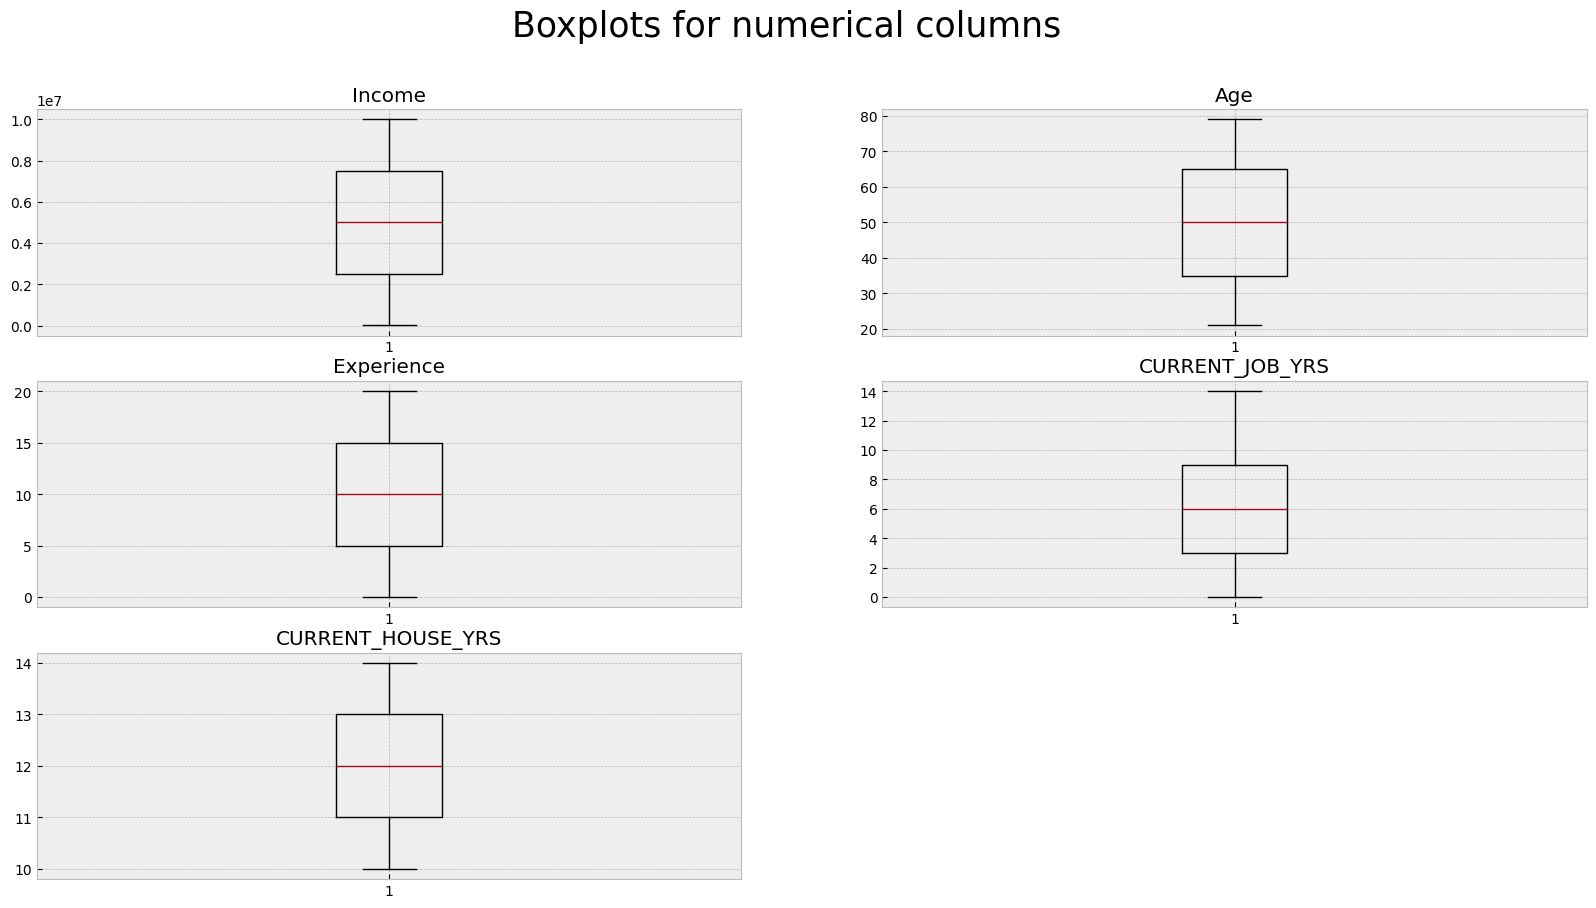

In [8]:
plt.style.use('bmh')
fig, axes = plt.subplots(3, 2, figsize=(20,10))
fig.suptitle('Boxplots for numerical columns', fontsize = 25)
for col, ax in zip(df[num_cols], axes.flat):
    ax.boxplot(df[col])
    ax.set_title(col)
fig.delaxes(axes[2][1])
plt.show()

As it can be seen on boxplots, we don't have any outliers on any numeric columns.

### B. Data cleaning

Before visualisation we need to clean object-type columns from not nessesary signs:

In [9]:
pattern = '[[]\d+[]]'

In [10]:
df['STATE'] = [re.sub(pattern, '', row) for row in df['STATE']]

In [11]:
df['CITY'] = [re.sub(pattern, '', row) for row in df['CITY']]

In [12]:
df['CITY'] = df['CITY'].str.replace('city', '')

In [13]:
df['STATE'] = [re.sub('_', ' ', row) for row in df['STATE']]

In [14]:
df['CITY'] = [re.sub('_', ' ', row) for row in df['CITY']]

In 2014 state Andhra Pradesh divided into Telangana and Andhra Pradesh (https://pl.wikipedia.org/wiki/Telangana). Because another dataset with wise data is from 2011, we need to change it into one state, how it was before.

In [15]:
df['STATE'] = [re.sub('Telangana', 'Andhra Pradesh', row) for row in df['STATE']]

In [16]:
df['CITY'] = [re.sub('Khora,', '', row) for row in df['CITY']]

In [17]:
df['CITY'] = df['CITY'].str.lstrip()

In [18]:
df['CITY'] = df['CITY'].str.rstrip()

### C. Data visualisations

First take a look for distriubutions of numeric columns, showed on histograms:

In [19]:
plt.style.use('bmh')

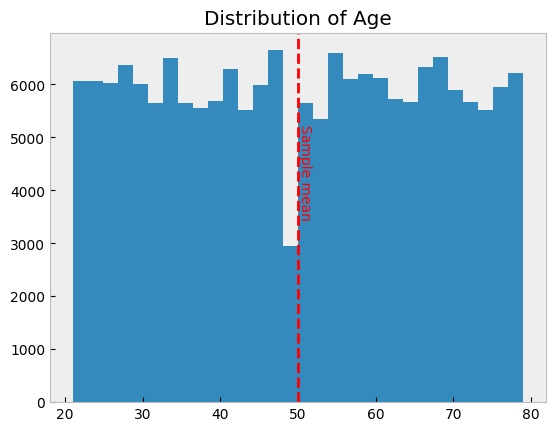

In [20]:
plt.hist(df['Age'], bins=30)
plt.axvline(df['Age'].mean(), c='red', linestyle='--')
plt.text(50, 3500, 'Sample mean', c='red', rotation=270)
plt.title('Distribution of Age')
plt.grid()
plt.show()

As it can be seen on this histogram - age groups are represented quite equally, excluding group little bit less of mean (and median).

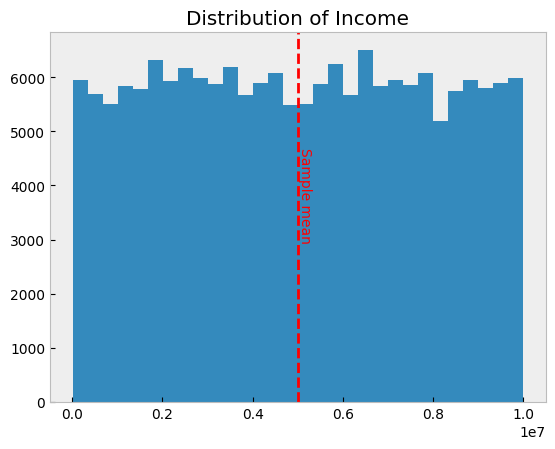

In [21]:
plt.hist(df['Income'], bins=30)
plt.axvline(df['Income'].mean(), c='red', linestyle='--')
plt.text(5e6, 3000, 'Sample mean', c='red', rotation=270)
plt.title('Distribution of Income')
plt.grid()
plt.show()

Here we see that inbcome groups are equally represented.

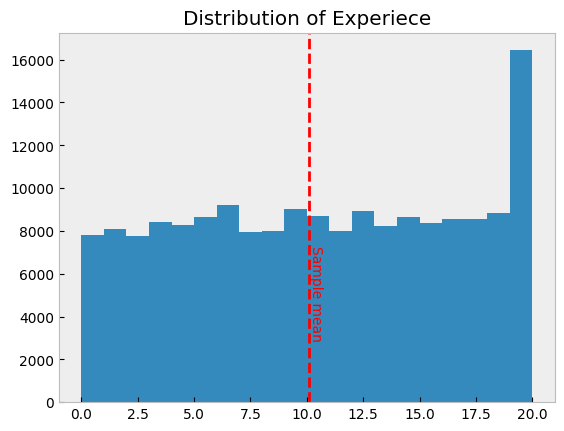

In [22]:
plt.hist(df['Experience'], bins=20)
plt.axvline(df['Experience'].mean(), c='red', linestyle='--')
plt.text(10.1, 3000, 'Sample mean', c='red', rotation=270)
plt.title('Distribution of Experiece')
plt.grid()
plt.show()

Work experience - we have here large representation of group whichg work around maximum value. It can be also explained by age - avarage 50 years old person will work longer.

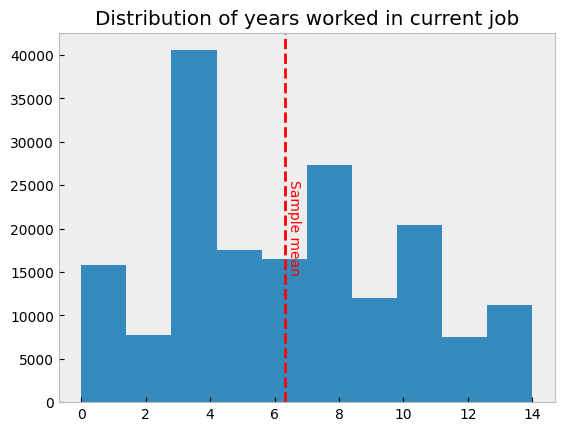

In [23]:
plt.hist(df['CURRENT_JOB_YRS'], bins=10)
plt.axvline(df['CURRENT_JOB_YRS'].mean(), c='red', linestyle='--')
plt.text(6.4, 15000, 'Sample mean', c='red', rotation=270)
plt.title('Distribution of years worked in current job')
plt.grid()
plt.show()

Years in current work - we can see large representation of people who works 3 years. 

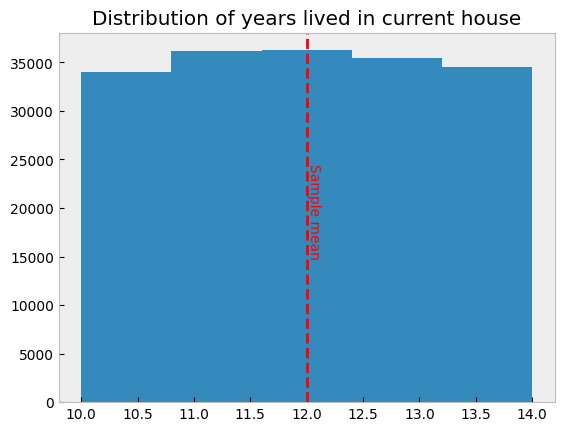

In [24]:
plt.hist(df['CURRENT_HOUSE_YRS'], bins=5)
plt.axvline(df['CURRENT_HOUSE_YRS'].mean(), c='red', linestyle='--')
plt.text(12, 15000, 'Sample mean', c='red', rotation=270)
plt.title('Distribution of years lived in current house')
plt.grid()
plt.show()

Groups in years lived in current house - this columns is quite equally distributed.

Let's take a look for numbers of values in object-type columns. First we need to check how many unique values we have in each columns.

In [25]:
for column in df.columns:
    if df[column].dtype == object:
        print(f'Column {column} has {df[column].nunique()} unique values.')

Column Married.Single has 2 unique values.
Column House_Ownership has 3 unique values.
Column Car_Ownership has 2 unique values.
Column Profession has 51 unique values.
Column CITY has 315 unique values.
Column STATE has 27 unique values.


Because of large number of unique values on 'CITY' column, this column will not be shown. Let's deep into data:

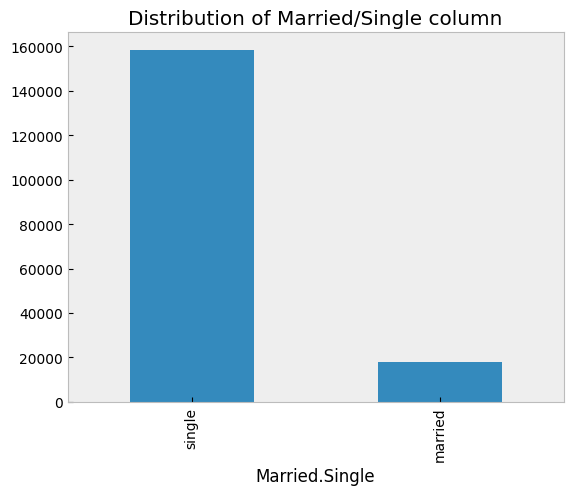

In [26]:
df['Married.Single'].value_counts().plot(kind='bar')
plt.title('Distribution of Married/Single column')
plt.show()

That's very interesting - single people dominate in our dataset.

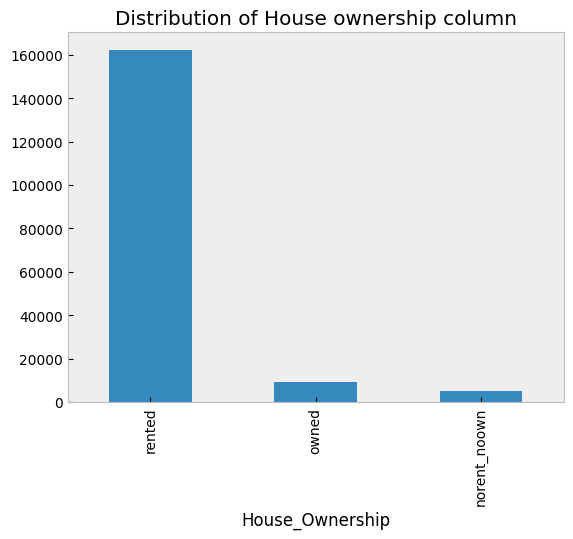

In [27]:
df['House_Ownership'].value_counts().plot(kind='bar')
plt.title('Distribution of House ownership column')
plt.show()

As we can see, most of people in our dataset are renting properties.

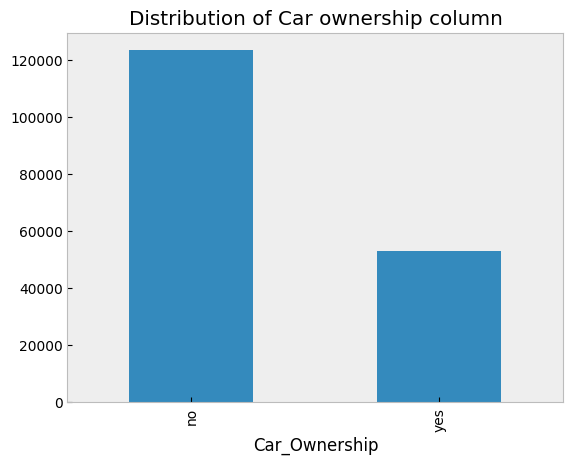

In [28]:
df['Car_Ownership'].value_counts().plot(kind='bar')
plt.title('Distribution of Car ownership column')
plt.show()

And do not have cars.

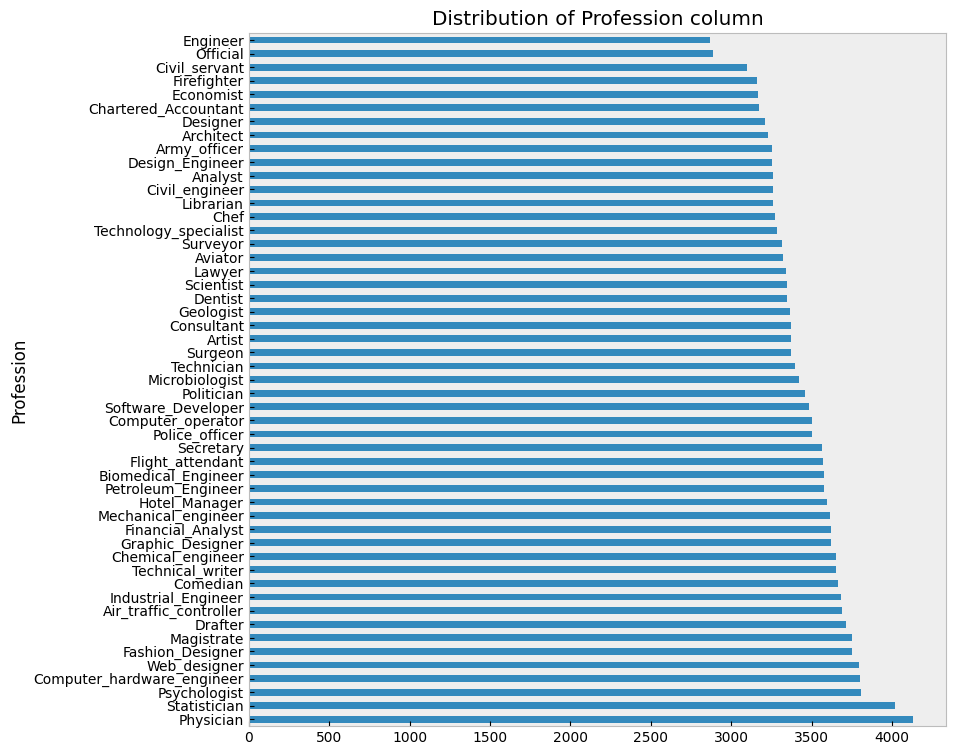

In [29]:
plt.figure(figsize=(9, 9))
df['Profession'].value_counts().plot(kind='barh')
plt.title('Distribution of Profession column')
plt.show()

On 'Profession' column we can see that profession with lowest representation is Engineer, and highest is Physician. But as we can seen on plot, data are quite equally distributed.

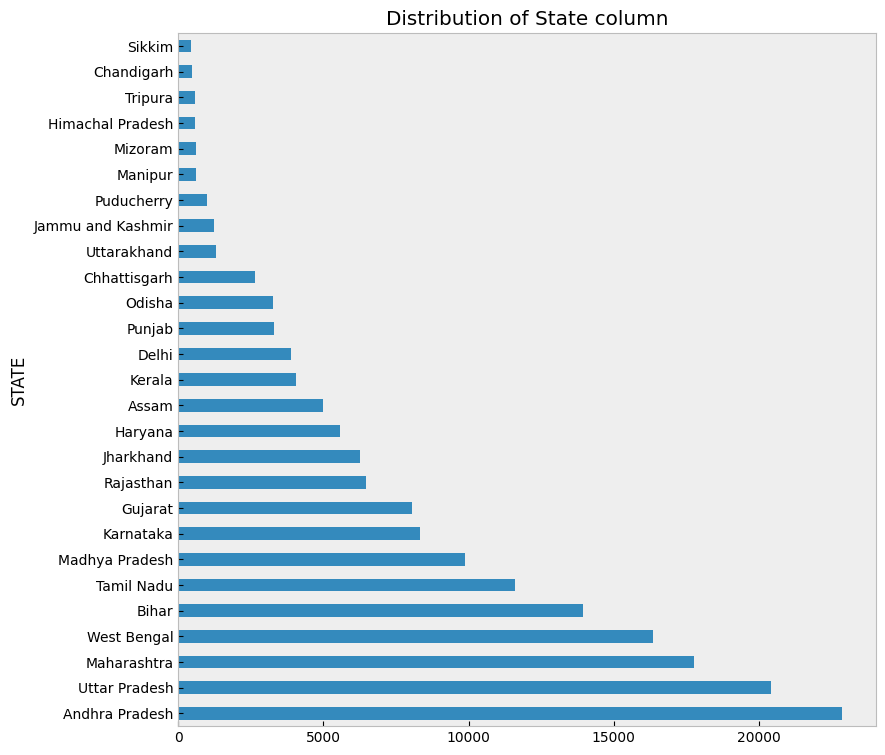

In [30]:
plt.figure(figsize=(9, 9))
df['STATE'].value_counts().plot(kind='barh')
plt.title('Distribution of State column')
plt.show()

Here on state column we can see that there is large difference in numbers between states. Some of them have just a little number of representatives. But for example Adhra Pradesh have large representation - more than 20 k records.

Next thing which I wan to show is heatmap of correlations between numerical columns:

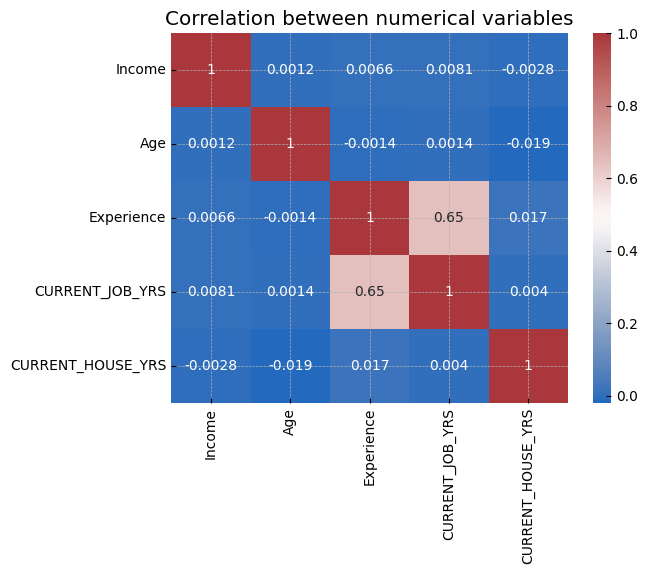

In [31]:
plt.title('Correlation between numerical variables')
sns.heatmap(df[df.columns[df.dtypes != 'object'][:-1]].corr(), annot=True, cmap='vlag')
plt.show()

We can see tha just 2 columns are corelated - Experience and CURRENT_JOB_YRS, which is quite logical - if you work in current place longer, you also have longer job experiance.

Let's look for numbers in target column:

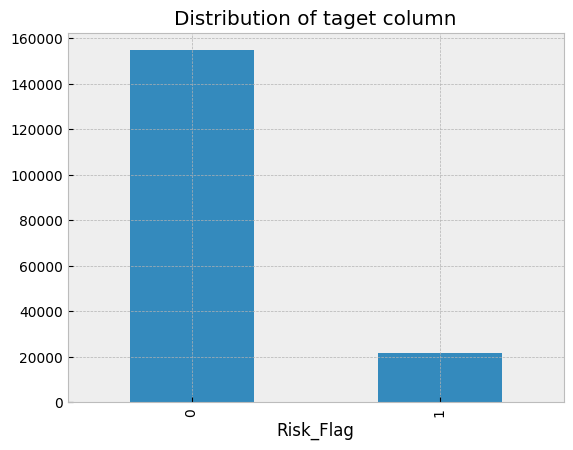

In [32]:
plt.style.use('bmh')
plt.title('Distribution of taget column')
df['Risk_Flag'].value_counts().plot(kind='bar')
plt.show()

As the plot shows - dataset is imbalanced which need specific aproach.

Another thing which is interesing for this dataset is distribution of income in categories:

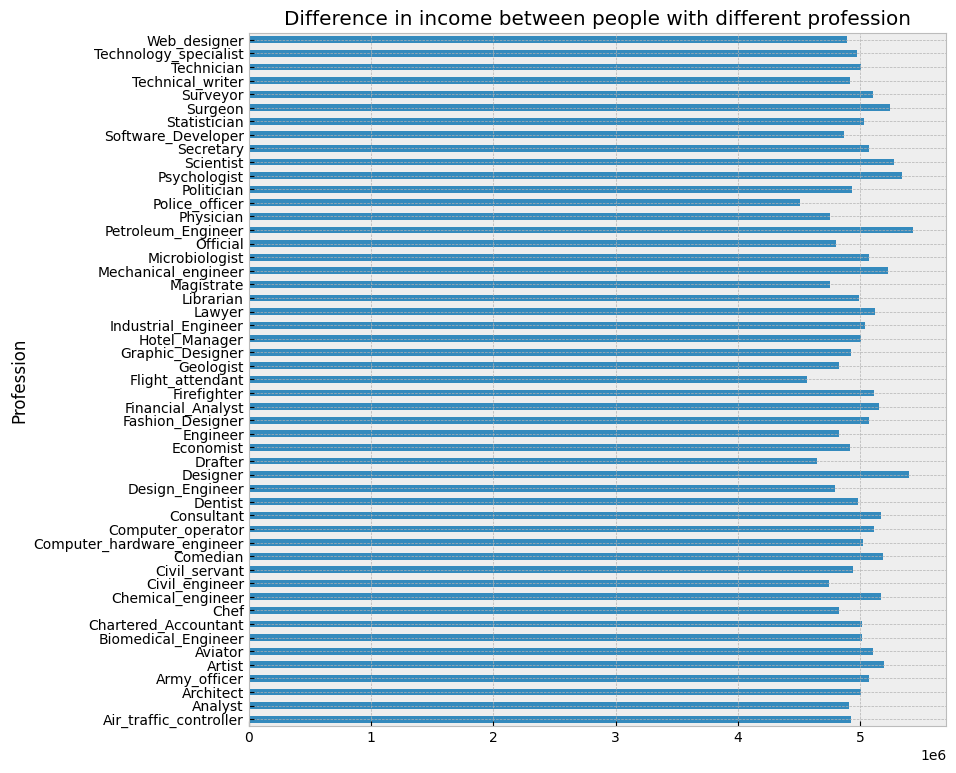

In [33]:
plt.figure(figsize=(9, 9))
df.groupby('Profession')['Income'].mean().plot(kind='barh')
plt.title('Difference in income between people with different profession')
plt.show()

In this dataset we don't see differences in incomes between professions.

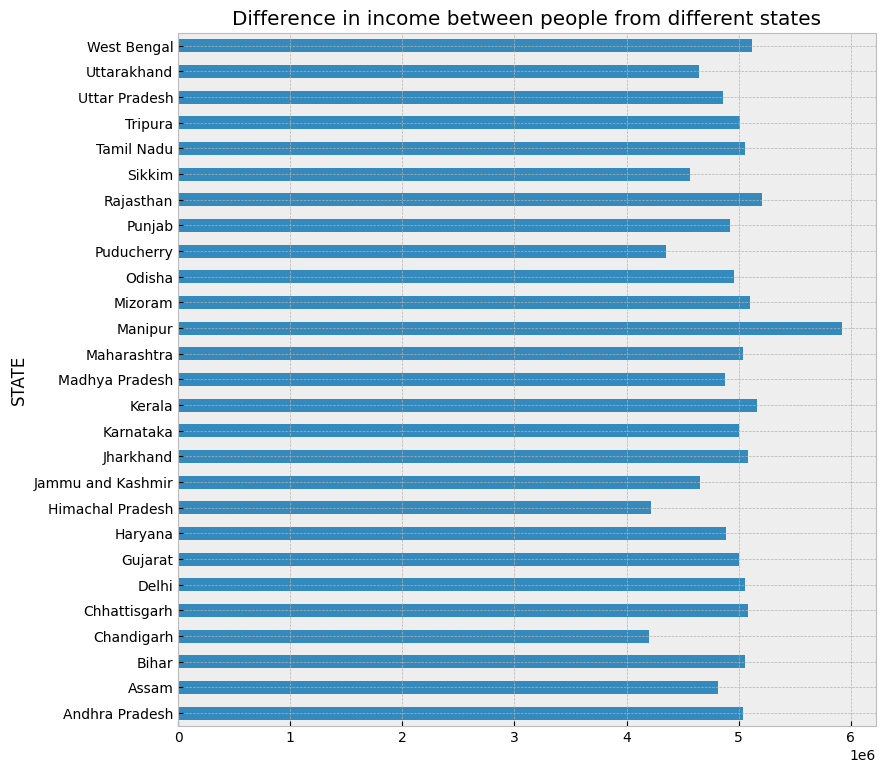

In [34]:
plt.figure(figsize=(9, 9))
df.groupby('STATE')['Income'].mean().plot(kind='barh')
plt.title('Difference in income between people from different states')
plt.show()

Also between states of ocupation tehere is not large difference between states. Just one state - Manipur have larger mean salary. There are few states wit lower salary than others: Puducherry, Himachal Pradesh and Chhattisgarh.

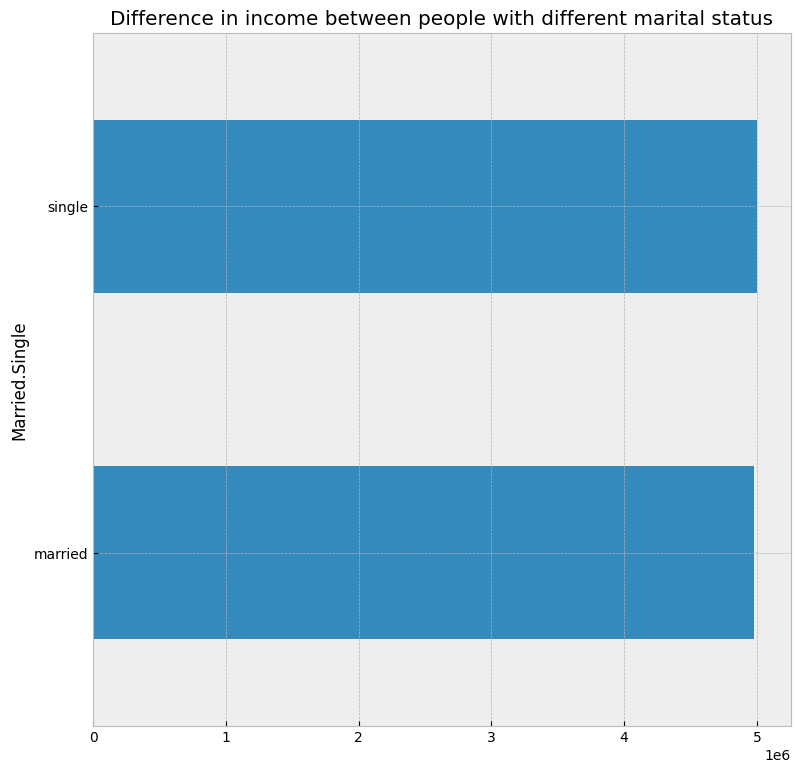

In [35]:
plt.figure(figsize=(9, 9))
df.groupby('Married.Single')['Income'].mean().plot(kind='barh')
plt.title('Difference in income between people with different marital status')
plt.show()

People are not different in average incme because of marital status.

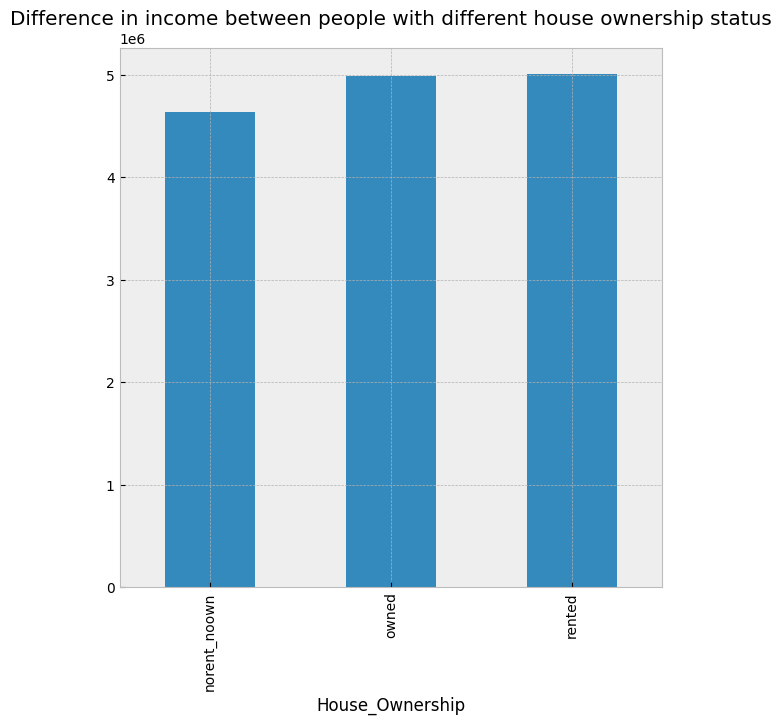

In [36]:
plt.figure(figsize=(7, 7))
df.groupby('House_Ownership')['Income'].mean().plot(kind='bar')
plt.title('Difference in income between people with different house ownership status')
plt.show()

Similar situation is with house ownership. We can just see difference in category norent_noown which maybe means that someone have different house ownership status - maybe that means that some of them live with family - they don't have enough money for renting or bnuying a house. 

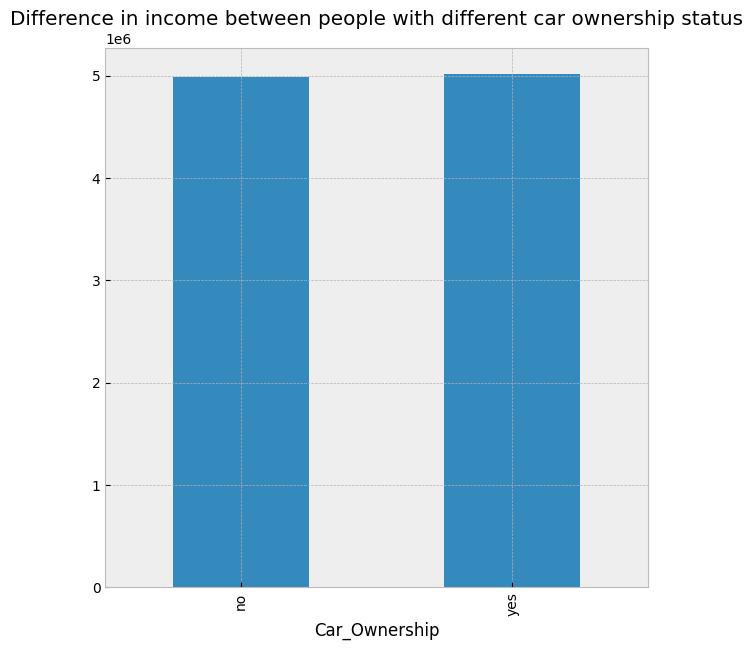

In [37]:
plt.figure(figsize=(7, 7))
df.groupby('Car_Ownership')['Income'].mean().plot(kind='bar')
plt.title('Difference in income between people with different car ownership status')
plt.show()

By looking on this plot we can conclude that larger salary doesnlt mean that you'll own a car.

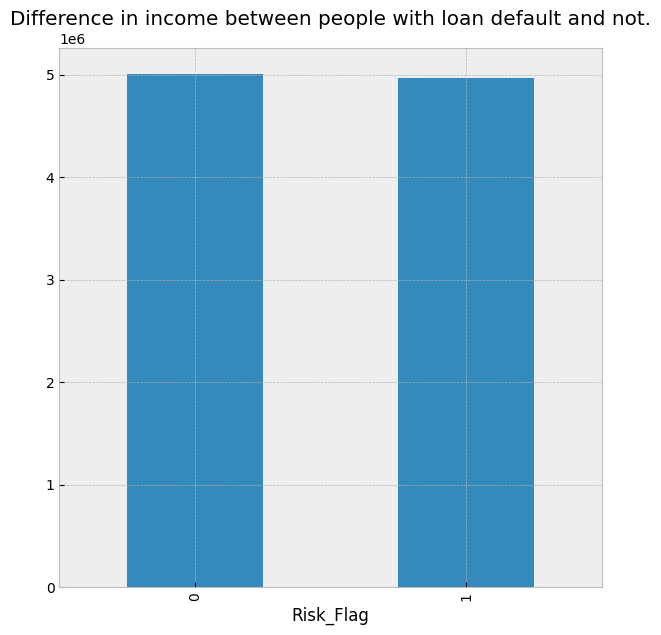

In [38]:
plt.figure(figsize=(7, 7))
df.groupby('Risk_Flag')['Income'].mean().plot(kind='bar')
plt.title('Difference in income between people with loan default and not.')
plt.show()

And finally - target column - what is very interesting - there is no difference in avarage income between peaple with loan default and not.

### D. Making new columns

In this section I want to produce new features. They will be made from existing columns.

#### a. Experience / life ratio

This feature will mean which part of life this person was working.

In [39]:
df['exp_life_ratio'] = df['Experience'] / df['Age']

Look at descriptive statistics:

In [40]:
df['exp_life_ratio'].describe()

count    176400.000000
mean          0.231819
std           0.175417
min           0.000000
25%           0.098039
50%           0.203125
75%           0.318182
max           0.952381
Name: exp_life_ratio, dtype: float64

And histogram:

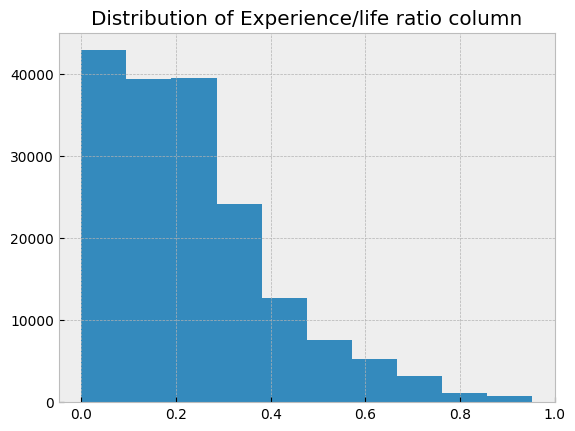

In [41]:
plt.hist(df['exp_life_ratio'])
plt.title('Distribution of Experience/life ratio column')
plt.show()

We can see that mean and median is around 20% lifetime worked. Also distribution is focused around this value.

#### b. Years in current job / experience ratio

Feature means what part of working years person worked in one, current place.

In [42]:
df['curr_exp_ratio'] = df['CURRENT_JOB_YRS'] / df['Experience']

With this feature we cen see another problem:

In [43]:
df.isna().sum()

Income                  0
Age                     0
Experience              0
Married.Single          0
House_Ownership         0
Car_Ownership           0
Profession              0
CITY                    0
STATE                   0
CURRENT_JOB_YRS         0
CURRENT_HOUSE_YRS       0
Risk_Flag               0
exp_life_ratio          0
curr_exp_ratio       7791
dtype: int64

As we can see we have some missing values in this feature. Let's take a look why:

In [44]:
df[df['curr_exp_ratio'].isna()].head()

Income  Age  Experience Married.Single House_Ownership Car_Ownership  \
Id                                                                              
27610   3753805   68           0         single          rented            no   
58908   7585777   33           0         single          rented            no   
103637  7231280   27           0         single          rented           yes   
41058   4386483   37           0         single          rented            no   
196533  2570783   55           0         single           owned            no   

            Profession          CITY              STATE  CURRENT_JOB_YRS  \
Id                                                                         
27610        Physician      Srinagar  Jammu and Kashmir                0   
58908          Analyst      Dehradun        Uttarakhand                0   
103637  Civil_engineer      Bareilly      Uttar Pradesh                0   
41058        Secretary     New Delhi              Delhi                0   
196533       Geologist  North Dumdum        West Bengal                0   

        CURRENT_HOUSE_YRS  Risk_Flag  exp_life_ratio  curr_exp_ratio  
Id                                                                    
27610                  13          0             0.0             NaN  
58908                  12          0             0.0             NaN  
103637                 10          0             0.0             NaN  
41058                  11          0             0.0             NaN  
196533                 11          0             0.0             NaN

As we can see, missing values we have because divided values (CURRENT_JOB_YEARS), are zeros. That means that for this purpose we need to change our new feature on those examples to 0.

In [45]:
df['curr_exp_ratio'] = df['curr_exp_ratio'].fillna(0)

Now we can continue work.

In [46]:
df['curr_exp_ratio'].describe()

count    176400.000000
mean          0.703924
std           0.313033
min           0.000000
25%           0.450000
50%           0.777778
75%           1.000000
max           1.000000
Name: curr_exp_ratio, dtype: float64

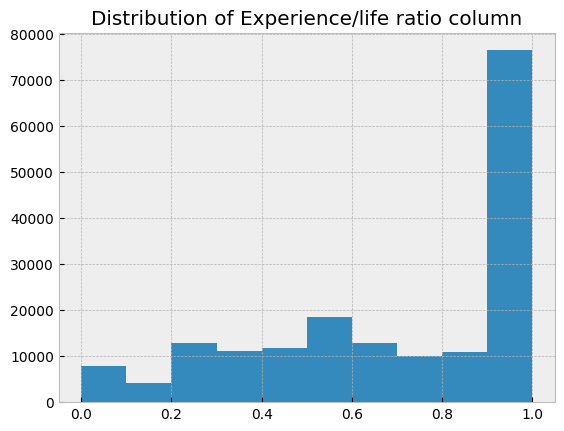

In [47]:
plt.hist(df['curr_exp_ratio'])
plt.title('Distribution of Experience/life ratio column')
plt.show()

As we can see more than 25 % of people worked in one place for whole their work experience. Also more than 75% of people work in the same, current place for almost half of their worklife. That means that people in our dataset do not change work often or have stable jobs.

#### c. Years lived in current house / age ratio

This feature measures which part of life person lives in current place.

In [48]:
df['house_life_ratio'] = df['CURRENT_HOUSE_YRS'] / df['Age']

In [49]:
df['house_life_ratio'].describe()

count    176400.000000
mean          0.276559
std           0.118083
min           0.126582
25%           0.184615
50%           0.240000
75%           0.342105
max           0.666667
Name: house_life_ratio, dtype: float64

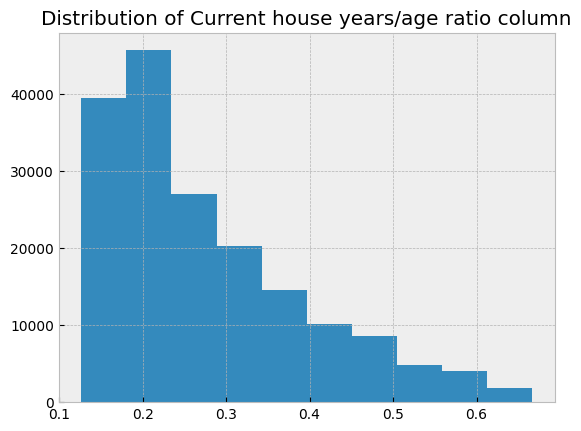

In [50]:
plt.hist(df['house_life_ratio'])
plt.title('Distribution of Current house years/age ratio column')
plt.show()

As we can se the major part of people included in dataset live 10-20% of their life in current place. 

### E. Analysis of wise state data

In [51]:
states = pd.read_csv('states.csv', index_col='States_Union Territories')

In [52]:
states.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Andaman and Nicobar Islands to West Bengal
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   2000-01-INC      32 non-null     int64  
 1   2011-12-INC      32 non-null     int64  
 2   2001 - LIT       32 non-null     float64
 3   2011- LIT        32 non-null     float64
 4   2001 - POP       32 non-null     int64  
 5   2011- POP        32 non-null     int64  
 6   2001 -SEX_Ratio  32 non-null     int64  
 7   2011 -SEX_Ratio  32 non-null     int64  
 8   2001 -UNEMP      32 non-null     int64  
 9   2011 -UNEMP      32 non-null     int64  
 10  2001 -Poverty    32 non-null     float64
 11  2011 -Poverty    32 non-null     float64
dtypes: float64(4), int64(8)
memory usage: 3.2+ KB


As we can se here we don't have missing values. Let me explain features (most of description taken from dataset source - https://www.kaggle.com/datasets/gokulrajkmv/indian-statewise-data-from-rbi):

"2000-01-INC = Income of each state for the year 2001
2011-12-INC = Income of each state for the year 2011

2001 - LIT = Literacy rate of each state for the year 2001
2011- LIT = Literacy rate of each state for the year 2011

2001 - POP = Total population of each state for the year 2001
2011- POP = Total population of each state for the year 2011

2001 -SEX_Ratio = Sex_Ratio of the each state for the year 2001
2011 -SEX_Ratio = Sex_Ratio of the each state for the year 2011

2001 -UNEMP = Unemployment rate of the each state for the year 2001
2011 -UNEMP = Unemployment rate of the each state for the year 2011

2001 -Poverty = Poverty rate of the each state for the year 2001
2011 -Poverty = Poverty rate of the each state for the year 2001

Unemployment Rate - for a month is calculated using the following formula: The monthly estimations for India are calculated as a ratio of the total estimated unemployed persons in India to the total estimated labor force for a month

Poverty rate = A common method used to estimate poverty in India is based on the income or consumption levels and if the income or consumption falls below a given minimum level, then the household is said to be Below the Poverty Line

state's Income measured using state domestic product - is the total value of goods and services produced during any financial year within the geographical boundaries of a state

Literacy rate - Total number of literate persons in a given age group, expressed as a percentage of the total population in that age group. The adult literacy rate measures literacy among persons aged 15 years and above, and the youth literacy rate measures literacy among persons aged 15 to 24 years"

Sex ratio - number of females for 1000 males.

Let;s take a look for descriptive statistics.

In [53]:
states.describe()

2000-01-INC    2011-12-INC  2001 - LIT  2011- LIT     2001 - POP  \
count     32.00000      32.000000   32.000000  32.000000      32.000000   
mean   19696.53125   74792.500000   69.810625  78.240312   32134.437500   
std    10191.63120   40960.182286   11.149199   8.733646   38054.631775   
min     6415.00000   22582.000000   47.000000  61.800000     356.000000   
25%    12965.75000   47958.000000   62.950000  71.712500    2218.000000   
50%    16418.00000   66413.000000   68.975000  77.465000   20989.500000   
75%    22781.50000   89198.000000   78.945000  86.090000   53765.000000   
max    49771.00000  211570.000000   90.860000  94.000000  166198.000000   

           2011- POP  2001 -SEX_Ratio  2011 -SEX_Ratio  2001 -UNEMP  \
count      32.000000         32.00000        32.000000    32.000000   
mean    37818.843750        928.87500       945.468750    21.406250   
std     45189.884314         56.70737        53.105485    20.731555   
min       381.000000        777.00000       818.000000     4.000000   
25%      2636.750000        896.75000       916.500000     8.000000   
50%     25448.000000        934.50000       949.000000    17.000000   
75%     62958.250000        969.00000       976.750000    25.000000   
max    199812.000000       1058.00000      1084.000000    93.000000   

       2011 -UNEMP  2001 -Poverty  2011 -Poverty  
count    32.000000      32.000000      32.000000  
mean     29.468750      22.627500      18.591563  
std      32.223999      12.279176      11.086188  
min       3.000000       3.480000       1.000000  
25%       9.000000      12.180000       9.855000  
50%      20.500000      21.395000      15.670000  
75%      28.250000      32.870000      29.985000  
max     151.000000      47.150000      39.930000

In [54]:
states.head()

2000-01-INC  2011-12-INC  2001 - LIT  2011- LIT  \
States_Union Territories                                                       
Andaman and Nicobar Islands        25047        89642       81.30      86.63   
Andhra Pradesh                     17195        64773       60.47      67.02   
Arunachal Pradesh                  15260        71366       54.34      65.39   
Assam                              12803        36320       63.25      72.19   
Bihar                               6415        22582       47.00      61.80   

                             2001 - POP  2011- POP  2001 -SEX_Ratio  \
States_Union Territories                                              
Andaman and Nicobar Islands         356        381              846   
Andhra Pradesh                    76210      84581              978   
Arunachal Pradesh                  1098       1384              893   
Assam                             26656      31206              935   
Bihar                             82999     104099              919   

                             2011 -SEX_Ratio  2001 -UNEMP  2011 -UNEMP  \
States_Union Territories                                                 
Andaman and Nicobar Islands              876           34           54   
Andhra Pradesh                           993            8           12   
Arunachal Pradesh                        938            5           17   
Assam                                    958           39           45   
Bihar                                    918           18           32   

                             2001 -Poverty  2011 -Poverty  
States_Union Territories                                   
Andaman and Nicobar Islands          20.99           1.00  
Andhra Pradesh                       15.77           9.20  
Arunachal Pradesh                    33.47          34.67  
Assam                                36.09          31.98  
Bihar                                42.60          33.74

As we can see most of values in the growed drom 2001 to 2011 except poverty rate. We probably see some mistakes in unamployment data (values above 100), but I'll not do anything with that.
Let's look for numbers on plots: 

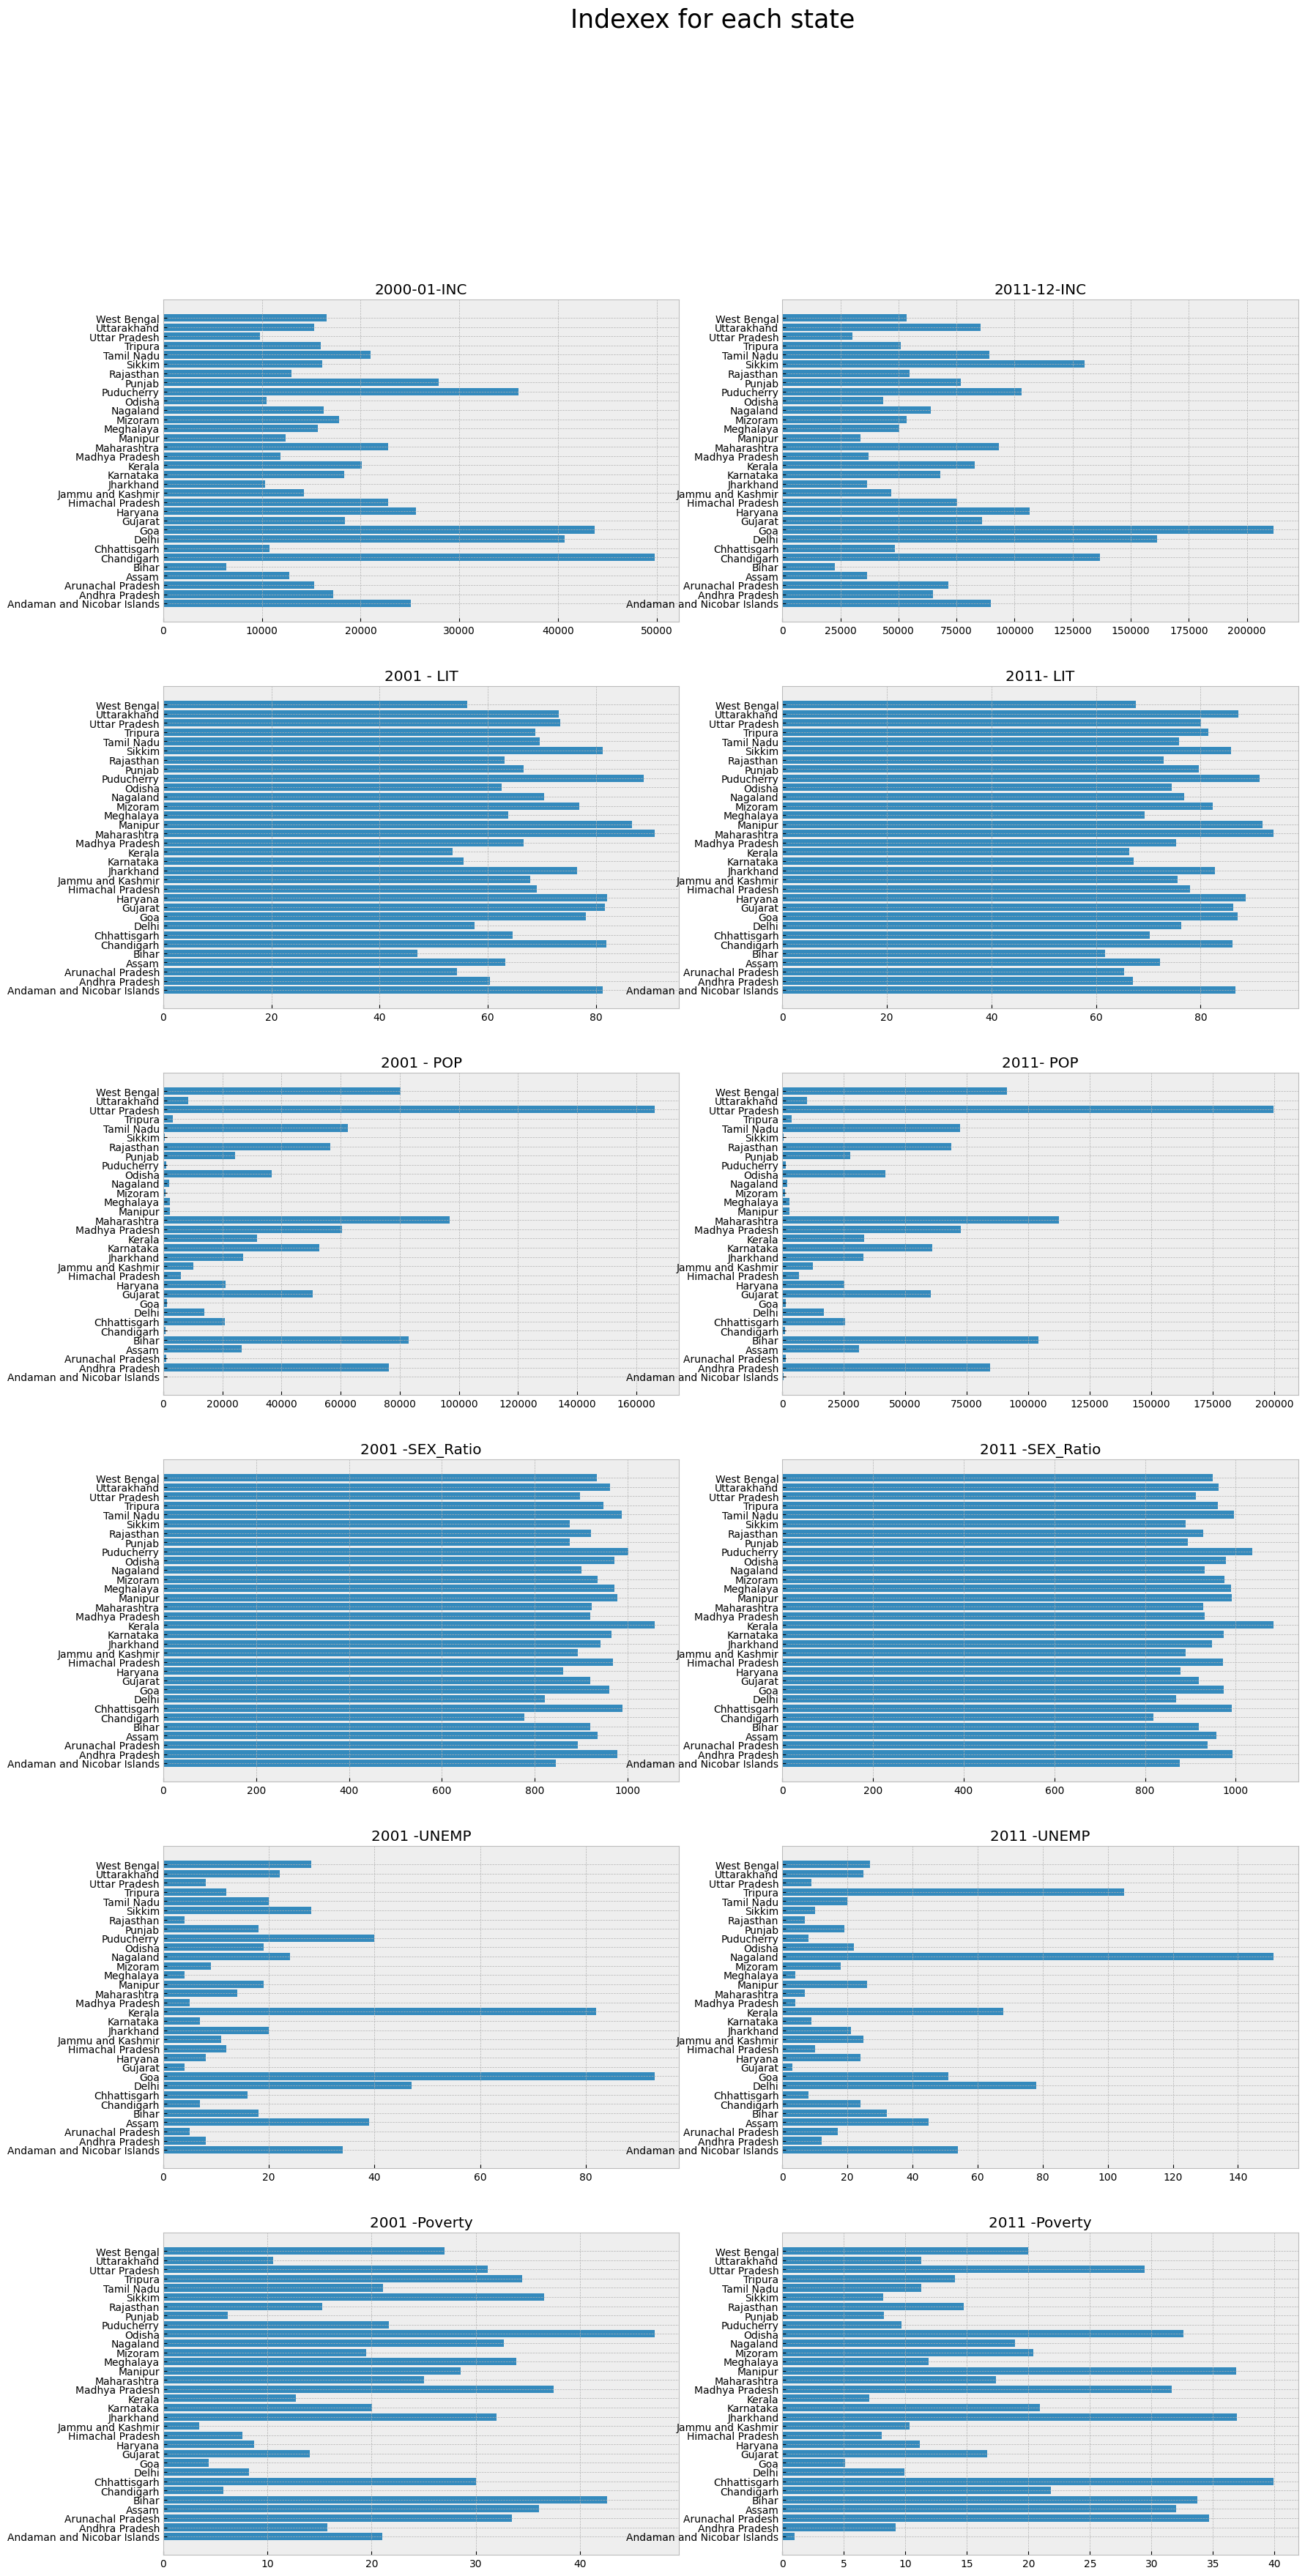

In [55]:
fig, axes = plt.subplots(6, 2, figsize=(20,40))
fig.suptitle('Indexex for each state', fontsize = 25)
for col, ax in zip(states.columns, axes.flat):
    ax.barh(states.index, states[col])
    ax.set_title(col)
plt.show()

For a first look we can see that data for population, sex ratio and literacy did't change structure much. Changes can be seen in income columns and poverty. Another fact is that there are large differences in the most of columns between states. That can mean that those features can be important. But because there are old data, can not be very important for modeling. Take a look for correlation heatmap.

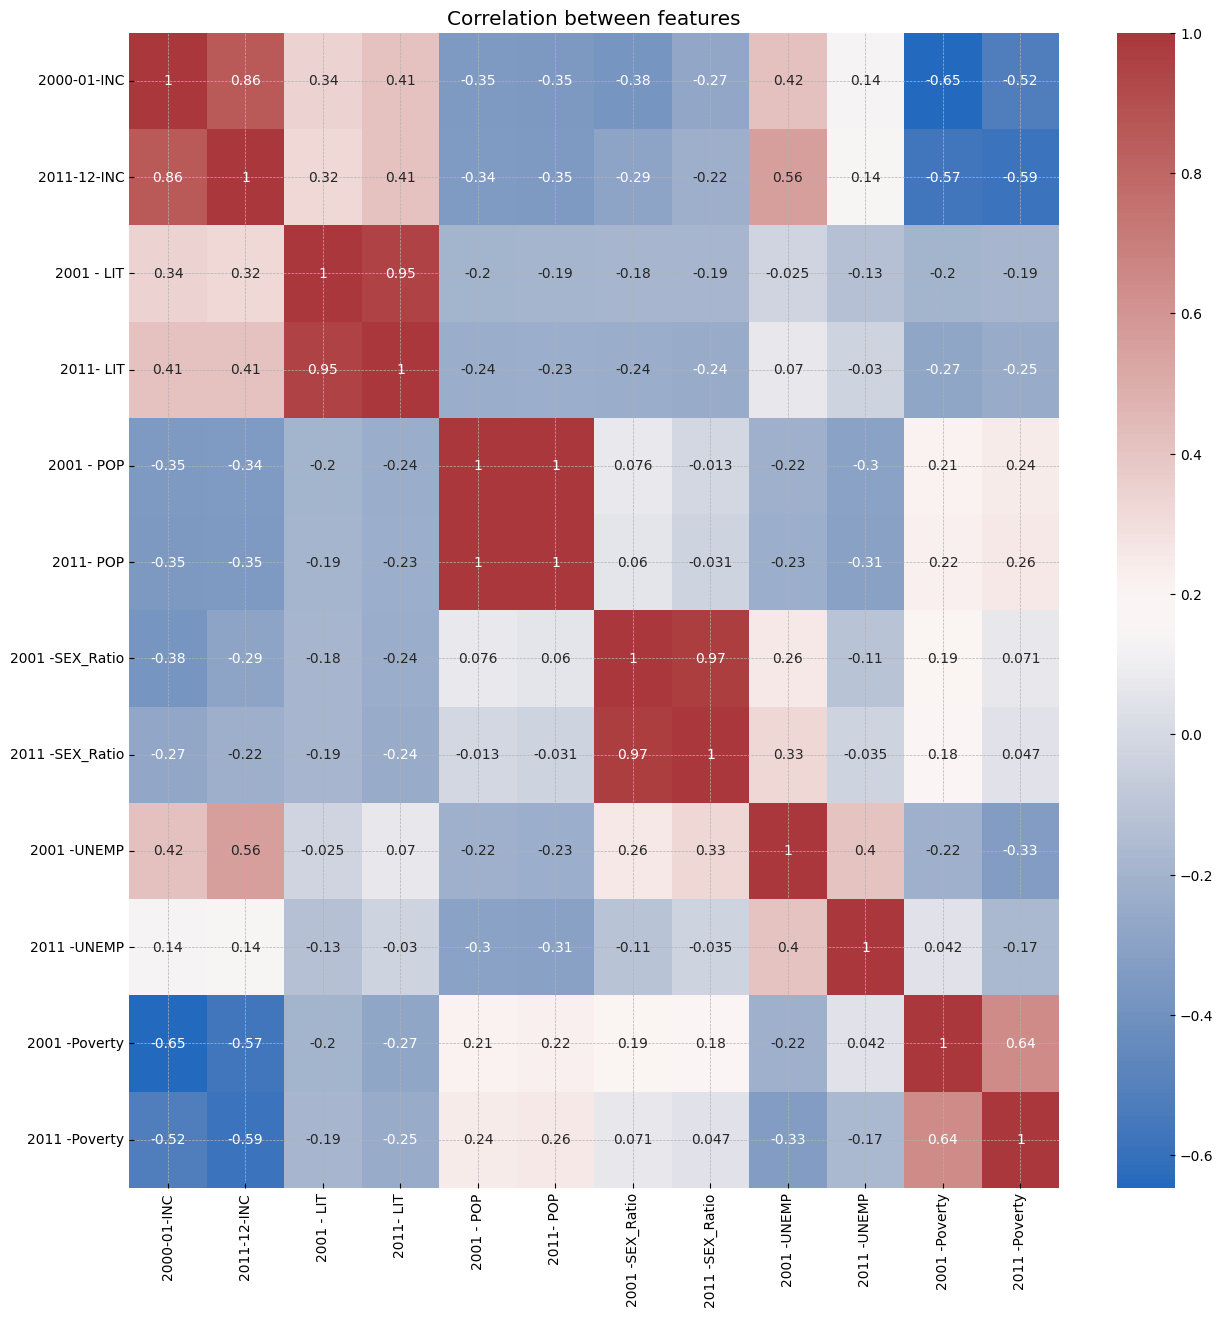

In [56]:
plt.figure(figsize=(15, 15))
plt.title('Correlation between features')
sns.heatmap(states.corr(), annot=True, cmap='vlag')
plt.show()

As we can see most of the data from the same area are corelated - what is quite logical thing. On that point suprising is unemployment rate - but it's maybe because of mistakes in data. High negative corelations between incomes and poverty rate is very logical explanation - if incomes are higher, poverty rate should be lower. Some weak corelations we can see between incomes and sex ratios and population. That can mean that males are earning more money and thwre are larger incomes in states with lower population - maybe specialists are payed better far away from populated places. We can also see some weak positive correlation between literacy rate and incomes - better educated populations are earning more. Also because of weak negative correlation of unemployment rates and population we can see tha there are more jobs in lower populated areas.

### F. Defining new features

I decided to make new feaures, which are explaining growth of each feature in thoese 10 years:

In [57]:
states['inc_diff'] = (states['2011-12-INC'] - states['2000-01-INC']) / states['2000-01-INC'] # income difference

In [58]:
states['lit_diff'] = (states['2011- LIT'] - states['2001 - LIT']) / states['2001 - LIT'] # literacy rate difference

In [59]:
states['pop_diff'] = (states['2011- POP'] - states['2001 - POP']) / states['2001 - POP'] # population difference

In [60]:
states['sex_diff'] = (states['2011 -SEX_Ratio'] - states['2001 -SEX_Ratio']) / states['2001 -SEX_Ratio'] # sex ratio difference

In [61]:
states['unemp_diff'] = (states['2011 -UNEMP'] - states['2001 -UNEMP']) / states['2001 -UNEMP'] # unemployment rate difference

In [62]:
states['pov_diff'] = (states['2011 -Poverty'] - states['2001 -Poverty']) / states['2001 -Poverty'] # poverty rate difference

Let's look for differences for each category:

In [63]:
diff_columns = states.columns.str.contains('diff')

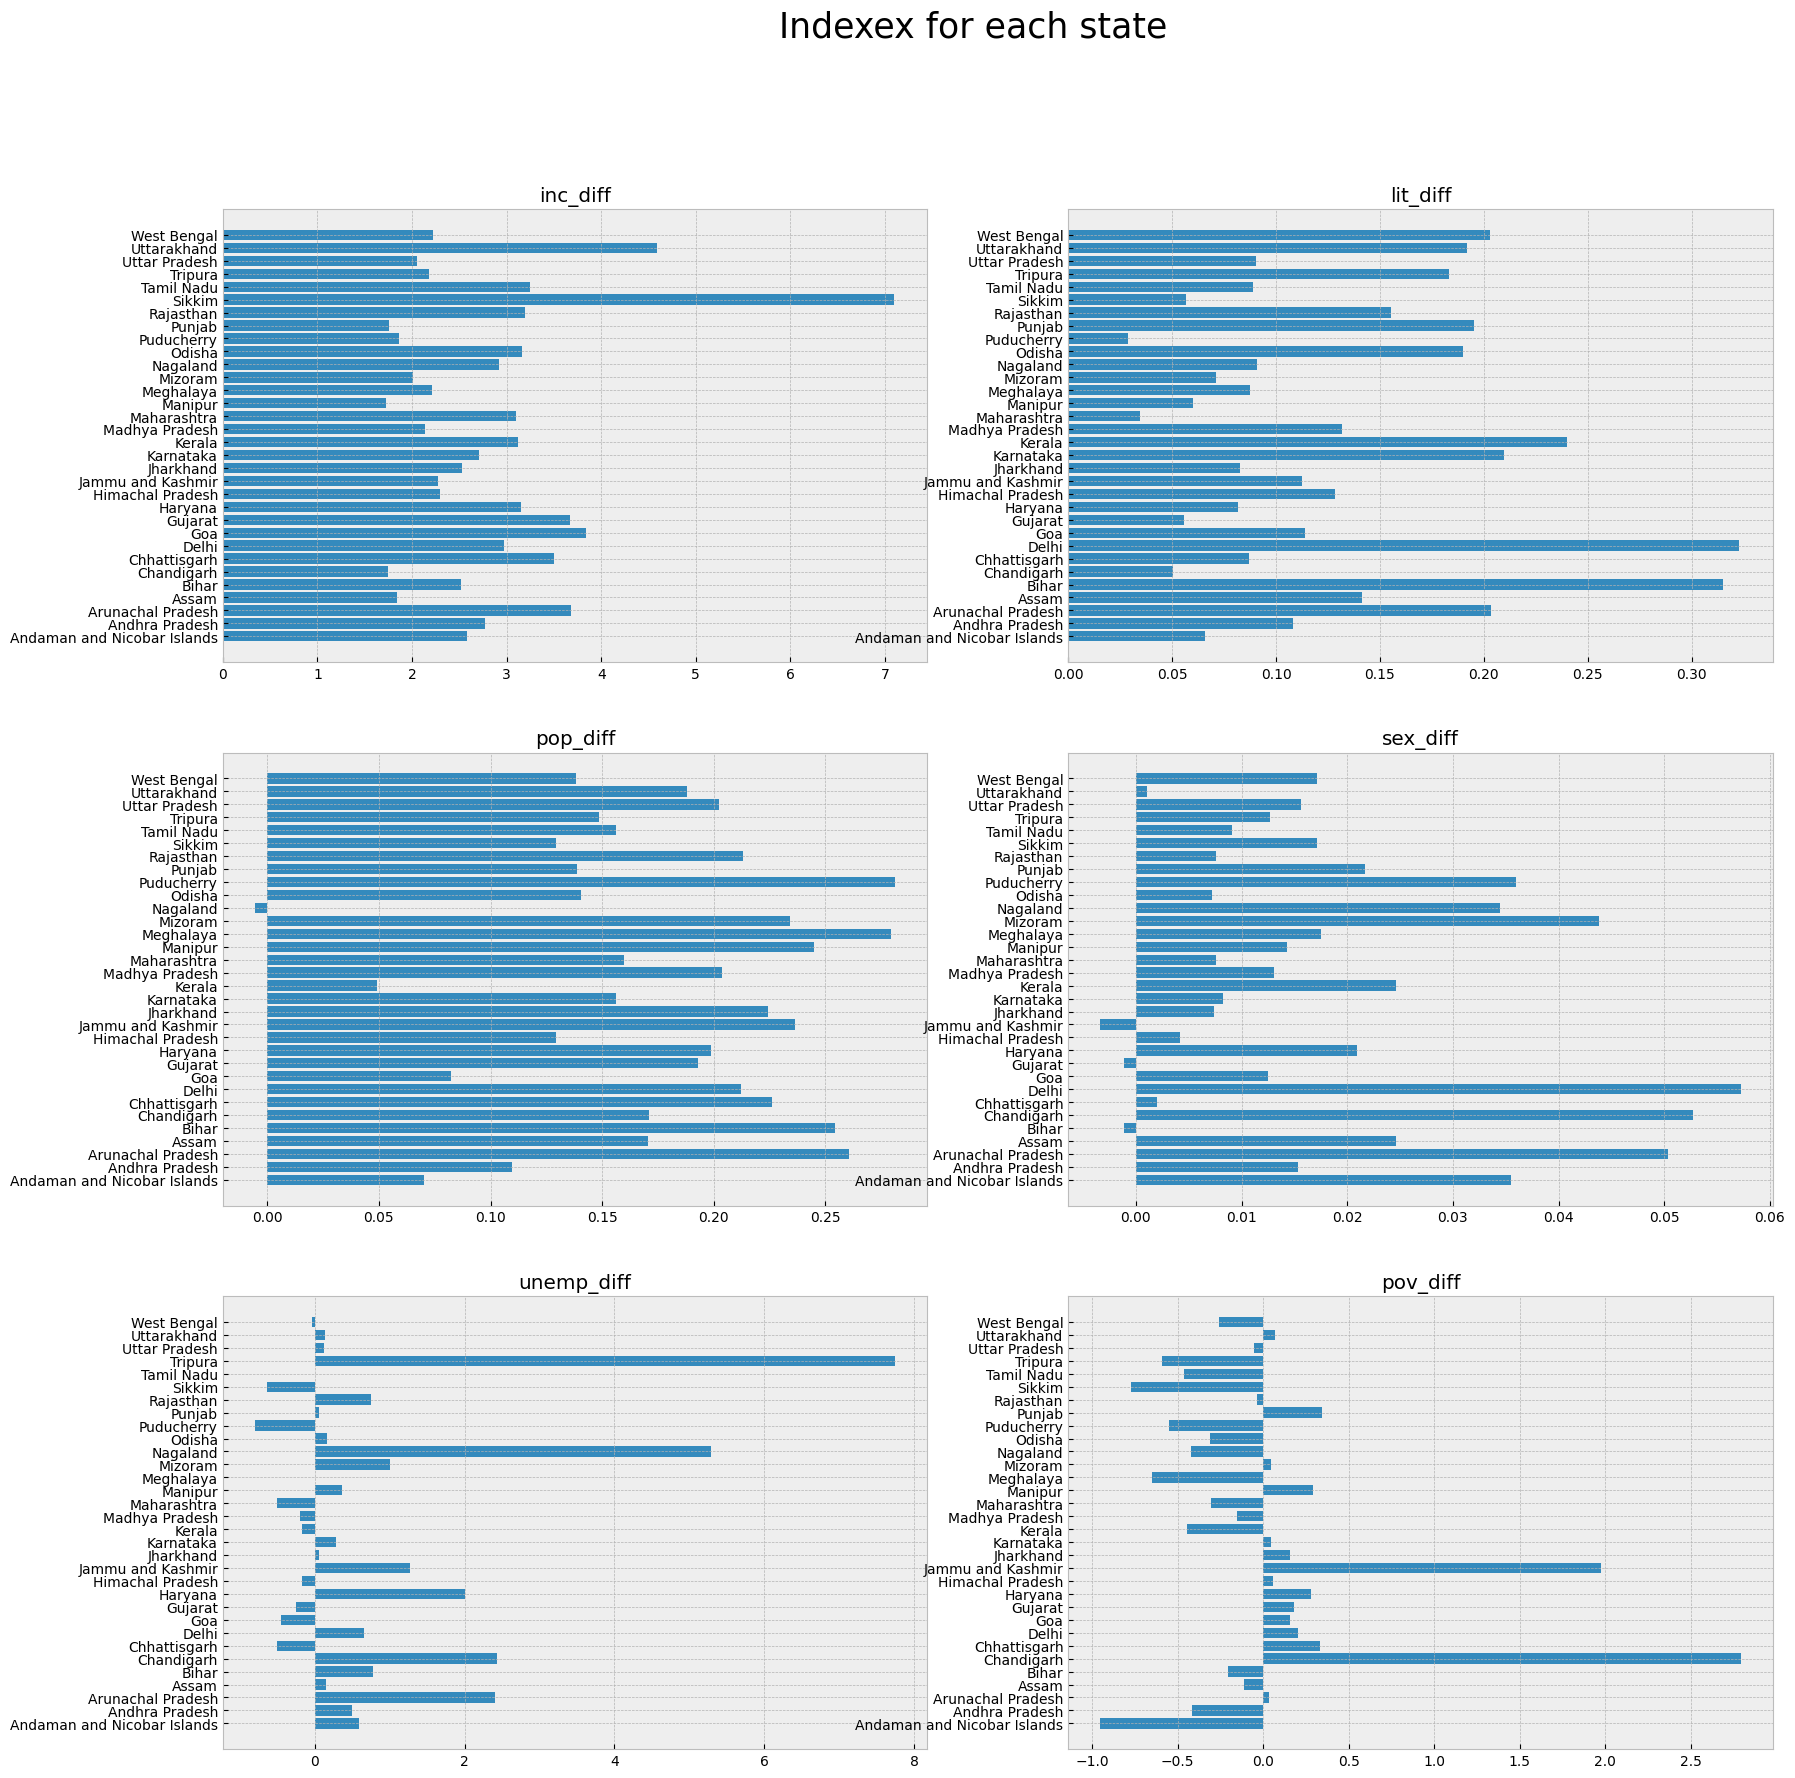

In [64]:
fig, axes = plt.subplots(3, 2, figsize=(20,20))
fig.suptitle('Indexex for each state', fontsize = 25)
for col, ax in zip(states[states.columns[diff_columns]], axes.flat):
    ax.barh(states.index, states[col])
    ax.set_title(col)
plt.show()

As the plots are showing incomes and literacy rate wwere growing in all of the states. Also population of females was growing in most of the states, but theere were some states where it went differently - but differences were not high. Change of income in Sikkim state was high, much higher than in other states. Interesting are changes in unemployment rate change and poverty rate change. Here we can see that on some states hose rates grew up, on some they got lower. Interesting is Sikkim state - where incomes grew up very hogh, unemplyment rate and poverty index got lower. In another side we can see for example Chandigarth state - where poferty grew up highly, unemployment rate too, but population and incomes did't grew up much.
Let's look for correlations between new features:

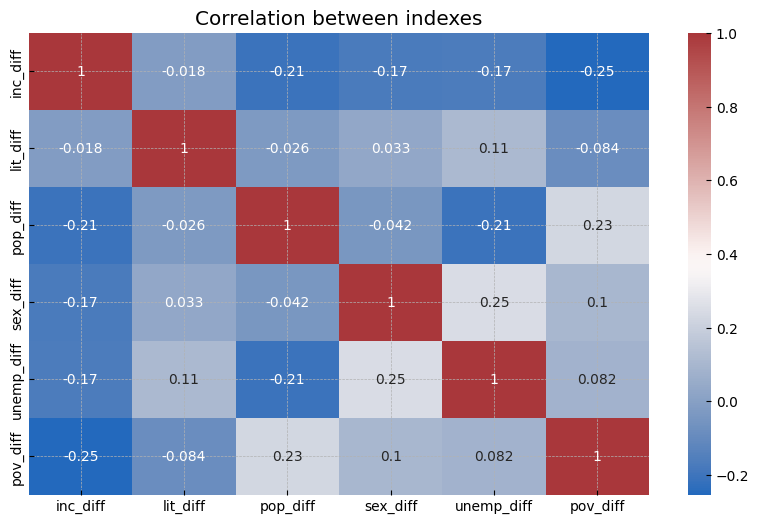

In [65]:
plt.figure(figsize=(10, 6))
plt.title('Correlation between indexes')
sns.heatmap(states[states.columns[diff_columns]].corr(), annot=True, cmap='vlag')
plt.show()

As I have seen before - we have some small negative correlation between income changes and poverty index changes. Heatmap also shows stat there is some small negative corelation between incomes and population, unemployment and sex ratio. Also we can see that there is small negative correlation between differences in population and unemployment. We can conclude:

- areas where population of females grew up slower have larger incomes and lower unemployemnt rates
- areas where populaion grew up faster have lower income growth and higher unemployment rate growth

At least those correlation cofficients are small (less than 0.3), so influence is low.

### G. Selecting columns from states vise data

For purpose of this project I've chosen the latest data from states, and new made columns with differences.

In [66]:
new_columns = states.columns.str.contains('2011') # chosing columns which include 2011 as a yeear

In [67]:
new_states = pd.concat([states[states.columns[new_columns]], states[states.columns[diff_columns]]], axis=1) # new data

In [68]:
new_states.head()

2011-12-INC  2011- LIT  2011- POP  \
States_Union Territories                                         
Andaman and Nicobar Islands        89642      86.63        381   
Andhra Pradesh                     64773      67.02      84581   
Arunachal Pradesh                  71366      65.39       1384   
Assam                              36320      72.19      31206   
Bihar                              22582      61.80     104099   

                             2011 -SEX_Ratio  2011 -UNEMP  2011 -Poverty  \
States_Union Territories                                                   
Andaman and Nicobar Islands              876           54           1.00   
Andhra Pradesh                           993           12           9.20   
Arunachal Pradesh                        938           17          34.67   
Assam                                    958           45          31.98   
Bihar                                    918           32          33.74   

                             inc_diff  lit_diff  pop_diff  sex_diff  \
States_Union Territories                                              
Andaman and Nicobar Islands  2.578952  0.065560  0.070225  0.035461   
Andhra Pradesh               2.766967  0.108318  0.109841  0.015337   
Arunachal Pradesh            3.676671  0.203349  0.260474  0.050392   
Assam                        1.836835  0.141344  0.170693  0.024599   
Bihar                        2.520187  0.314894  0.254220 -0.001088   

                             unemp_diff  pov_diff  
States_Union Territories                           
Andaman and Nicobar Islands    0.588235 -0.952358  
Andhra Pradesh                 0.500000 -0.416614  
Arunachal Pradesh              2.400000  0.035853  
Assam                          0.153846 -0.113882  
Bihar                          0.777778 -0.207981

In [69]:
new_states[new_states.columns[new_states.columns.str.contains('diff')]].describe()

inc_diff   lit_diff   pop_diff   sex_diff  unemp_diff   pov_diff
count  32.000000  32.000000  32.000000  32.000000   32.000000  32.000000
mean    2.833232   0.130511   0.174892   0.018313    0.719805   0.007448
std     1.048890   0.076005   0.067274   0.016184    1.743045   0.716563
min     1.724149   0.028491  -0.005528  -0.003363   -0.800000  -0.952358
25%     2.170146   0.078937   0.138803   0.007554   -0.167683  -0.417985
50%     2.644387   0.110410   0.179524   0.014826    0.145105  -0.046260
75%     3.167556   0.190227   0.224700   0.024581    0.756944   0.163100
max     7.093985   0.322922   0.281314   0.057247    7.750000   2.793043

At least we can see that in most of the states poverty index got lower, but in average poverty did't change - on some of he states we have large changes.

### H. Preparing data with population from cities

In [70]:
medium_cities = pd.read_csv('medium_cities.csv', na_values='―') # nans have '-' value

In [71]:
medium_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Rank                      254 non-null    int64 
 1   City                      254 non-null    object
 2   Population(2011)[5]       254 non-null    object
 3   Population(2001)          237 non-null    object
 4   State or union territory  254 non-null    object
dtypes: int64(1), object(4)
memory usage: 10.0+ KB


As we can see we have sove missing data in population from 2001. Maybe because those cities weren't of the list of largest cities in 2001.

At least columns in this dataset are quite clear, and don't need explanation.

Another problem is fact that columsn which should include numbers are object type data. Let's taske a look for first rows:

In [72]:
medium_cities.head(5)

Rank                City Population(2011)[5] Population(2001)  \
0    47            Guwahati             963,429          809,895   
1    48          Chandigarh             960,787          808,515   
2    49  Thiruvananthapuram             957,730          744,983   
3    50             Solapur             951,118          872,478   
4    51    Hubballi-Dharwad             943,857          786,195   

  State or union territory  
0                    Assam  
1               Chandigarh  
2                   Kerala  
3              Maharashtra  
4                Karnataka

That data contains commas , to read them easier.

In [73]:
medium_cities['City'] = [re.sub(pattern, '', row) for row in medium_cities['City']] # the same problew like with previous data

Let's start editing our data with writing short function:

In [74]:
def pop_column_converter(col, pattern=pattern):

    """
    Clean and convert population-like values into integers.

    This function takes a column (list, tuple, or pandas Series) of 
    population values that may contain commas, text, or other symbols, 
    removes unwanted characters based on a regex pattern, and converts 
    valid numeric strings into integers. Non-numeric or missing values 
    are converted to ``numpy.nan``.

    Parameters
    ----------
    col : iterable
        An iterable (list, tuple, or pandas Series) containing population values 
        as strings or other types.
    pattern : str, optional
        A regex pattern specifying which characters to remove from string values.
        Default is ``r'[^\d]'``, which removes all non-digit characters.

    Returns
    -------
    list of int or numpy.nan
        A list where each element is an integer (if conversion is successful) 
        or ``numpy.nan`` (if conversion fails or value is missing).

    Examples
    --------
    >>> data = ["1,234", "56,789", None, "12a,345", "N/A"]
    >>> pop_column_converter(data)
    [1234, 56789, nan, 12345, nan]
    """
    
    pop_list = []
        
    for row in col:
        if type(row) == str:
            row = re.sub(pattern, '', row) # delete signs from pattern
            row = re.sub(',', '', row) # delete commas 
            row = int(row) # change into numeric data
        else:
            row = np.nan
        pop_list.append(row)

    return pop_list

Now editing:

In [75]:
medium_cities['Population(2001)'] = pop_column_converter(medium_cities['Population(2001)'])

In [76]:
medium_cities['Population(2011)[5]'] = pop_column_converter(medium_cities['Population(2011)[5]'])

Now we can check descriptive statistics:

In [77]:
medium_cities.describe()

Rank  Population(2011)[5]  Population(2001)
count  254.00000           254.000000        237.000000
mean   173.50000        336110.078740     278543.088608
std     73.46768        204734.179456     162715.270865
min     47.00000        101520.000000      79190.000000
25%    110.25000        197257.250000     168323.000000
50%    173.50000        266832.500000     220749.000000
75%    236.75000        413081.500000     341755.000000
max    300.00000        963429.000000     872478.000000

As we can see mean population grew up. Also on the list of largest cities we had in 2001 cities with less than 100 k of population. In 2011 lowest populatin was higher than 100k.
take a loook for missing data:

In [78]:
medium_cities.isna().sum()

Rank                         0
City                         0
Population(2011)[5]          0
Population(2001)            17
State or union territory     0
dtype: int64

For purpose of this project i want to make extra column with include population changes of cities of residence. That can mean two thing - people in those cities have more choildren, which is important for our dataset, and people are migrating to those areas - maybe because of better job opportuniies. Also population changes as we saw before can have influance for quality of lifestyle.

In [79]:
medium_cities['pop_change'] = (medium_cities['Population(2011)[5]'] - medium_cities['Population(2001)']) / medium_cities['Population(2001)']

In [80]:
medium_cities.isna().sum()

Rank                         0
City                         0
Population(2011)[5]          0
Population(2001)            17
State or union territory     0
pop_change                  17
dtype: int64

Because I'll no use for dataset older data, we will just fill missing data wih mean population change.

In [81]:
medium_cities['pop_change'] = medium_cities['pop_change'].fillna(medium_cities['pop_change'].mean())

In [82]:
medium_cities.describe()

Rank  Population(2011)[5]  Population(2001)  pop_change
count  254.00000           254.000000        237.000000  254.000000
mean   173.50000        336110.078740     278543.088608    0.294483
std     73.46768        204734.179456     162715.270865    0.400456
min     47.00000        101520.000000      79190.000000   -0.172595
25%    110.25000        197257.250000     168323.000000    0.136439
50%    173.50000        266832.500000     220749.000000    0.224765
75%    236.75000        413081.500000     341755.000000    0.294483
max    300.00000        963429.000000     872478.000000    4.052518

Selecting columns:

In [83]:
medium_cities = medium_cities[['City', 'Population(2011)[5]', 'pop_change']]

In [84]:
medium_cities.head()

City  Population(2011)[5]  pop_change
0            Guwahati               963429    0.189573
1          Chandigarh               960787    0.188335
2  Thiruvananthapuram               957730    0.285573
3             Solapur               951118    0.090134
4    Hubballi-Dharwad               943857    0.200538

The same operations I'll make witth largest cities dataset:

In [85]:
big_cities = pd.read_csv('big_cities.csv', na_values='―')

In [86]:
big_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Rank                      46 non-null     int64 
 1   City                      46 non-null     object
 2   Population(2011)[3]       46 non-null     object
 3   Population(2001)[3][a]    46 non-null     object
 4   State or union territory  46 non-null     object
 5   Ref                       46 non-null     object
dtypes: int64(1), object(5)
memory usage: 2.3+ KB


In [87]:
big_cities.head()

Rank       City Population(2011)[3] Population(2001)[3][a]  \
0     1     Mumbai          12,442,373             11,978,450   
1     2      Delhi          11,034,555              9,879,172   
2     3  Bangalore           8,443,675              5,682,293   
3     4  Hyderabad           6,993,262              5,496,960   
4     5  Ahmedabad           5,577,940              4,470,006   

  State or union territory  Ref  
0              Maharashtra  [3]  
1                    Delhi  [3]  
2                Karnataka  [3]  
3                Telangana  [3]  
4                  Gujarat  [3]

In [88]:
big_cities['City'] = [re.sub(pattern, '', row) for row in big_cities['City']]

In [89]:
big_cities['Population(2001)[3][a]'] = pop_column_converter(big_cities['Population(2001)[3][a]'])

In [90]:
big_cities['Population(2011)[3]'] = pop_column_converter(big_cities['Population(2011)[3]'])

In [91]:
big_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Rank                      46 non-null     int64 
 1   City                      46 non-null     object
 2   Population(2011)[3]       46 non-null     int64 
 3   Population(2001)[3][a]    46 non-null     int64 
 4   State or union territory  46 non-null     object
 5   Ref                       46 non-null     object
dtypes: int64(3), object(3)
memory usage: 2.3+ KB


In [92]:
big_cities['pop_change'] = (big_cities['Population(2011)[3]'] - big_cities['Population(2001)[3][a]']) / big_cities['Population(2001)[3][a]']

In [93]:
big_cities.describe()

Rank  Population(2011)[3]  Population(2001)[3][a]  pop_change
count  46.000000         4.600000e+01            4.600000e+01   46.000000
mean   23.500000         2.521369e+06            2.066496e+06    0.280220
std    13.422618         2.574967e+06            2.306140e+06    0.234542
min     1.000000         1.001694e+06            5.186010e+05   -0.018306
25%    12.250000         1.123506e+06            9.441880e+05    0.127395
50%    23.500000         1.535878e+06            1.090594e+06    0.245709
75%    34.750000         2.675427e+06            2.152462e+06    0.336839
max    46.000000         1.244237e+07            1.197845e+07    1.357091

In [94]:
big_cities = big_cities[['City', 'Population(2011)[3]', 'pop_change']]

### I. Concatenating datasets and final preparations

I'll change names of columns form both datasets which are including population data form cities in those two datasets o be the same:

In [95]:
big_cities.columns = ['City', 'Population', 'pop_change']

In [96]:
medium_cities.columns = ['City', 'Population', 'pop_change']

Concatenation:

In [97]:
cities = pd.concat([big_cities, medium_cities])

Now we have one dataset with population data from cities. Let's start merging datasets:

In [98]:
df = df.merge(new_states, left_on='STATE', right_on=new_states.index, how='left')

In [99]:
df.isna().sum()

Income               0
Age                  0
Experience           0
Married.Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
exp_life_ratio       0
curr_exp_ratio       0
house_life_ratio     0
2011-12-INC          0
2011- LIT            0
2011- POP            0
2011 -SEX_Ratio      0
2011 -UNEMP          0
2011 -Poverty        0
inc_diff             0
lit_diff             0
pop_diff             0
sex_diff             0
unemp_diff           0
pov_diff             0
dtype: int64

As we can see after merging data from states dataset we don't have missineg values. Now it's time for citierds dataset:

In [100]:
df = df.merge(cities, left_on='CITY', right_on='City', how='left')

In [101]:
df.isna().sum()

Income                   0
Age                      0
Experience               0
Married.Single           0
House_Ownership          0
Car_Ownership            0
Profession               0
CITY                     0
STATE                    0
CURRENT_JOB_YRS          0
CURRENT_HOUSE_YRS        0
Risk_Flag                0
exp_life_ratio           0
curr_exp_ratio           0
house_life_ratio         0
2011-12-INC              0
2011- LIT                0
2011- POP                0
2011 -SEX_Ratio          0
2011 -UNEMP              0
2011 -Poverty            0
inc_diff                 0
lit_diff                 0
pop_diff                 0
sex_diff                 0
unemp_diff               0
pov_diff                 0
City                 20828
Population           20828
pop_change           20828
dtype: int64

Here we have large problem - some of data is missing. It is understandable - not all of the people live in  big or medium cities.

In [102]:
df[df['City'].isna()]['CITY'].value_counts()

CITY
Jorhat             764
Giridih            740
Bidhannagar        731
Bareilly           724
Dibrugarh          696
Silchar            685
Anantapuram        683
Mahbubnagar        662
Ambarnath          637
Malda              636
Pondicherry        630
Raebareli          625
Hazaribagh         616
Mehsana            611
Tezpur             608
Tinsukia           602
Medininagar        601
Ballia             584
Nagaon             578
Pudukkottai        566
Kumbakonam         559
Phagwara           557
Berhampore         554
Phusro             546
Chinsurah          546
Morbi              546
Shimoga            538
Kalyan-Dombivli    520
Bongaigaon         503
Udupi              484
Nagercoil          479
Ramgarh            469
Hosur              436
Gangtok            430
Hubliâ€“Dharwad    372
Katni              310
Name: count, dtype: int64

Here we can see list of cities with numbers where data is missing. We can have two reasons - those cities or towns are smaller and our datase about cities do not include them. Another option is that they grew up faster - we have old data.
Let's look for percentage of missing data:

In [103]:
df.isna().sum()[-1] / len(df)

0.11659920841520693

We can see our missing data is almost 12 %. It is not large part of datase, but it needs some actions. I decided that because of the reason which I was writing about - column with population I'll fill with lowest number. That's because those cities can include less people, or just grew up that now there are little bit larger. 

In [104]:
df['Population'] = df['Population'].fillna(min(df['Population']))

Population change column I'll fill with mean value, for 12% of data I think it will not change a lot in modeling.

In [105]:
df['pop_change'] = df['pop_change'].fillna(np.mean(df['pop_change']))

Instead of having lots of categorical data I decided to delate columns with cities and states names. Having more than 300 addictional columns in y opinion will not help.

In [106]:
df = df.drop(columns=['CITY', 'STATE', 'City'])

In this stage I want to divide columns into categorical and numerical:

In [107]:
df_object = df[df.columns[df.dtypes == 'object']]

In [108]:
df_object.head()

Married.Single House_Ownership Car_Ownership             Profession
0         single          rented            no              Architect
1         single          rented            no                Drafter
2         single          rented            no               Comedian
3        married          rented            no  Technology_specialist
4        married          rented            no         Microbiologist

In [109]:
df_number = df[df.columns[df.dtypes != 'object']]

In [110]:
y = df['Risk_Flag'] # target column

In [111]:
df_number = df_number.drop(['Risk_Flag'], axis=1) # excluding targett column

Let's finally look for correlations between all of the numerical columns:

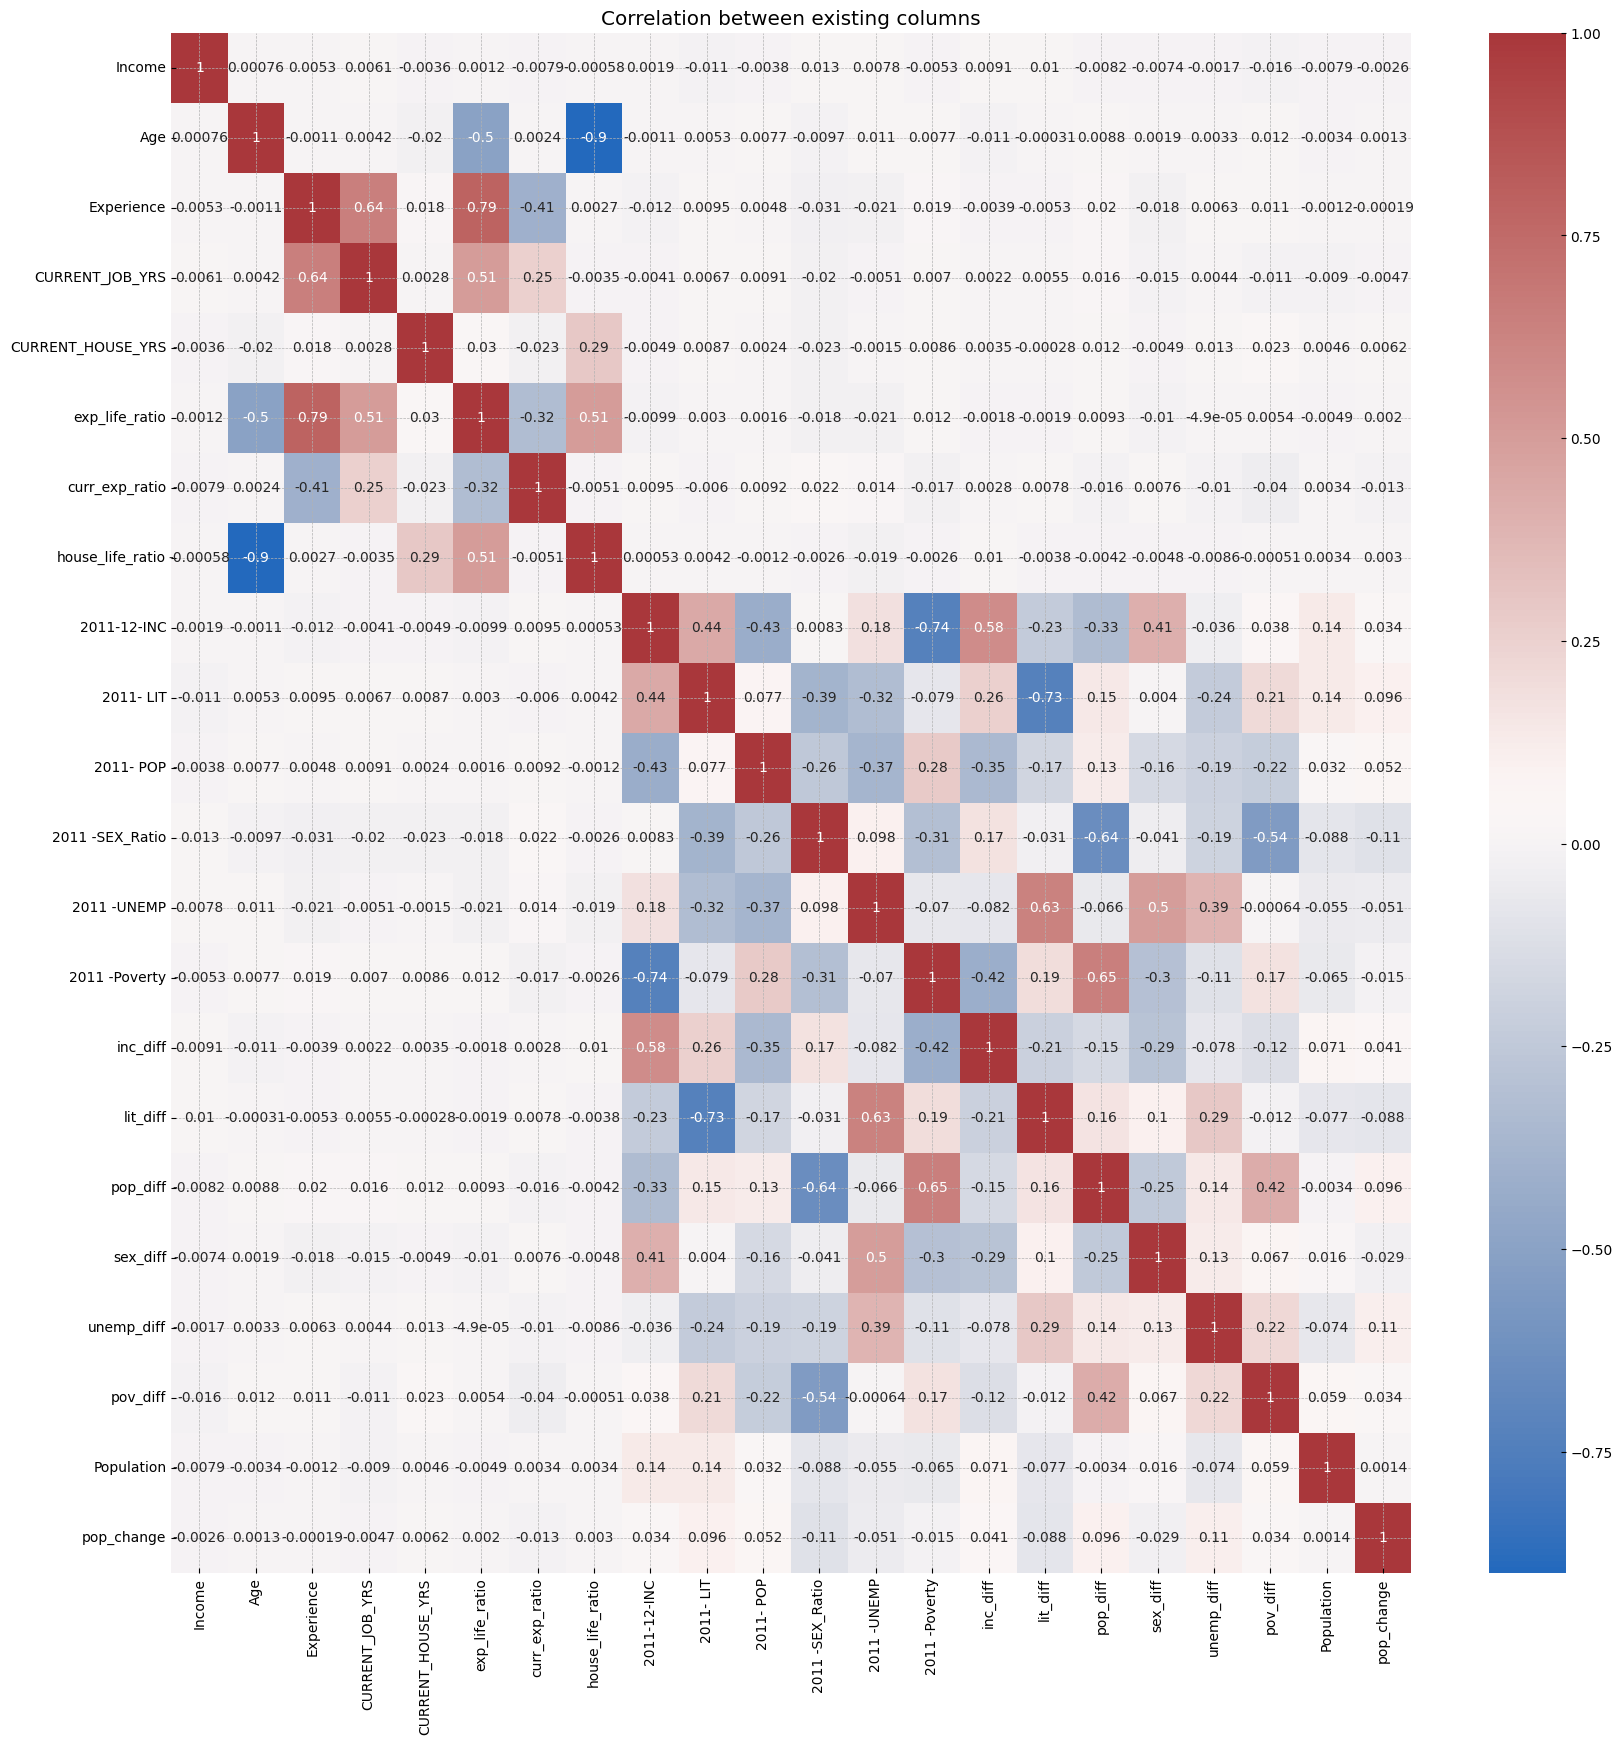

In [112]:
plt.figure(figsize=(20, 20))
plt.title('Correlation between existing columns')
sns.heatmap(df_number.corr(), annot=True, cmap='vlag')
plt.show()

As we can see larger correlations we have just between features in part which include personal data, and between part which include general data.

In [113]:
dummy_df = pd.get_dummies(df_object).astype('int') #One hot encoding

Let's cocatenate data to have whole dataset.

In [114]:
X = pd.concat([df_number, dummy_df], axis=1)

In [115]:
numeric_columns = df_number.columns #for selecting numeric columns

In [116]:
oh_columns = dummy_df.columns # dummy columns

Divide into train and test set:

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

For numeric columns I'll use MinMaxScaler - that will help wit predictions for some of the models:

In [118]:
scaler = MinMaxScaler()

In [119]:
X_train_sc = scaler.fit_transform(X_train[numeric_columns])

In [120]:
X_train_df = pd.DataFrame(X_train_sc, columns=numeric_columns, index=X_train.index) #changing into dataframe

And final concatenation of dummy columns and numerical columns:

In [121]:
X_train_full = pd.concat([X_train_df, X_train[oh_columns]], axis=1)

The same operations I'll perform with test set:

In [122]:
X_test_sc = scaler.transform(X_test[numeric_columns])

In [123]:
X_test_df = pd.DataFrame(X_test_sc, columns=numeric_columns, index=X_test.index)

In [124]:
X_test_full = pd.concat([X_test_df, X_test[oh_columns]], axis=1)

## 3. Predicting and modelling

Because dataset is imbalanced we needd special aproach. For usage of this project I'll use sample weights, to give more weight for default values.

In [125]:
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)


### A. Modelling

#### a. Logistic regression

In [126]:
lr = LogisticRegression(solver='saga', max_iter=5000) # saga solver and high max_iter value because we have large dataset
lr.fit(X_train_full, y_train, sample_weight=sample_weight)
y_lr = lr.predict(X_test_full)

In [127]:
print(classification_report(y_test, y_lr, zero_division=0))

              precision    recall  f1-score   support

           0       0.90      0.53      0.67     31351
           1       0.14      0.56      0.23      4375

    accuracy                           0.54     35726
   macro avg       0.52      0.55      0.45     35726
weighted avg       0.81      0.54      0.62     35726



As we can see linear model is no performing well with our problem. At least Logistic Regression can find 56% of default data, but just 14% of it's predictions are real defaults.

#### b. Decision Tree Classifier

In [128]:
dt = DecisionTreeClassifier()
dt.fit(X_train_full, y_train, sample_weight=sample_weight)
y_dt = dt.predict(X_test_full)

In [129]:
print(classification_report(y_test, y_dt, zero_division=0))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93     31351
           1       0.50      0.81      0.62      4375

    accuracy                           0.88     35726
   macro avg       0.73      0.85      0.77     35726
weighted avg       0.91      0.88      0.89     35726



Decission tree classifier performs much better - with f1_score of 0.62. Quite good result. Recall 0.81 it sounds well, but half of the predicted default are not already defaults.

#### c. Random Forest Classifier

In [130]:
rf =RandomForestClassifier()
rf.fit(X_train_full, y_train, sample_weight=sample_weight)
y_rf = rf.predict(X_test_full)

In [131]:
print(classification_report(y_test, y_rf, zero_division=0))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94     31351
           1       0.55      0.76      0.64      4375

    accuracy                           0.90     35726
   macro avg       0.76      0.84      0.79     35726
weighted avg       0.91      0.90      0.90     35726



Here we can see some improvement at f1 score comparing to both previous models. Recall is lower, but precission grew up. 

#### d. LGBM Classifier

In [132]:
lgbm = LGBMClassifier(n_estimators=10000) # default value of n_estimators (100) is too low to learn anything in this huge dataset
lgbm.fit(X_train_full, y_train, sample_weight=sample_weight)
y_lgbm = lgbm.predict(X_test_full)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17499, number of negative: 125404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1855
[LightGBM] [Info] Number of data points in the train set: 142903, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [133]:
print(classification_report(y_test, y_lgbm, zero_division=0))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     31351
           1       0.55      0.77      0.64      4375

    accuracy                           0.89     35726
   macro avg       0.76      0.84      0.79     35726
weighted avg       0.91      0.89      0.90     35726



LGBM have he same result on F1 like Random Forest Classifier, but it's just because of rounding - here we can see some improvement in recall. At least this model have better precission than Decission Tree Classifier - so we can be more sure that someone who will pay payments for loan will receive it.

### B. Analysis of chosen model

As a model for further analysis I've chosen LGBM Classifier. Let's look for some other metrics:

In [134]:
roc_auc = roc_auc_score(y_test, y_lgbm)

In [135]:
print(f'Roc auc score is {round(roc_auc, 2)}')

Roc auc score is 0.84


As we can see roc auc score is 0.84, so our model explains mostt of the data. Let's look for it at roc auc curve:

In [136]:
y_proba = lgbm.predict_proba(X_test_full)[:,1]

In [137]:
fpr, tpr, threshold = roc_curve(y_test, y_proba)

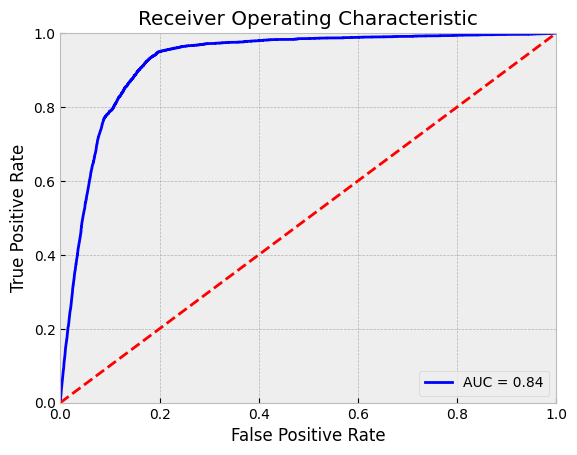

In [138]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Another important information what we ccan take from the model is which features are important for him to modelling:

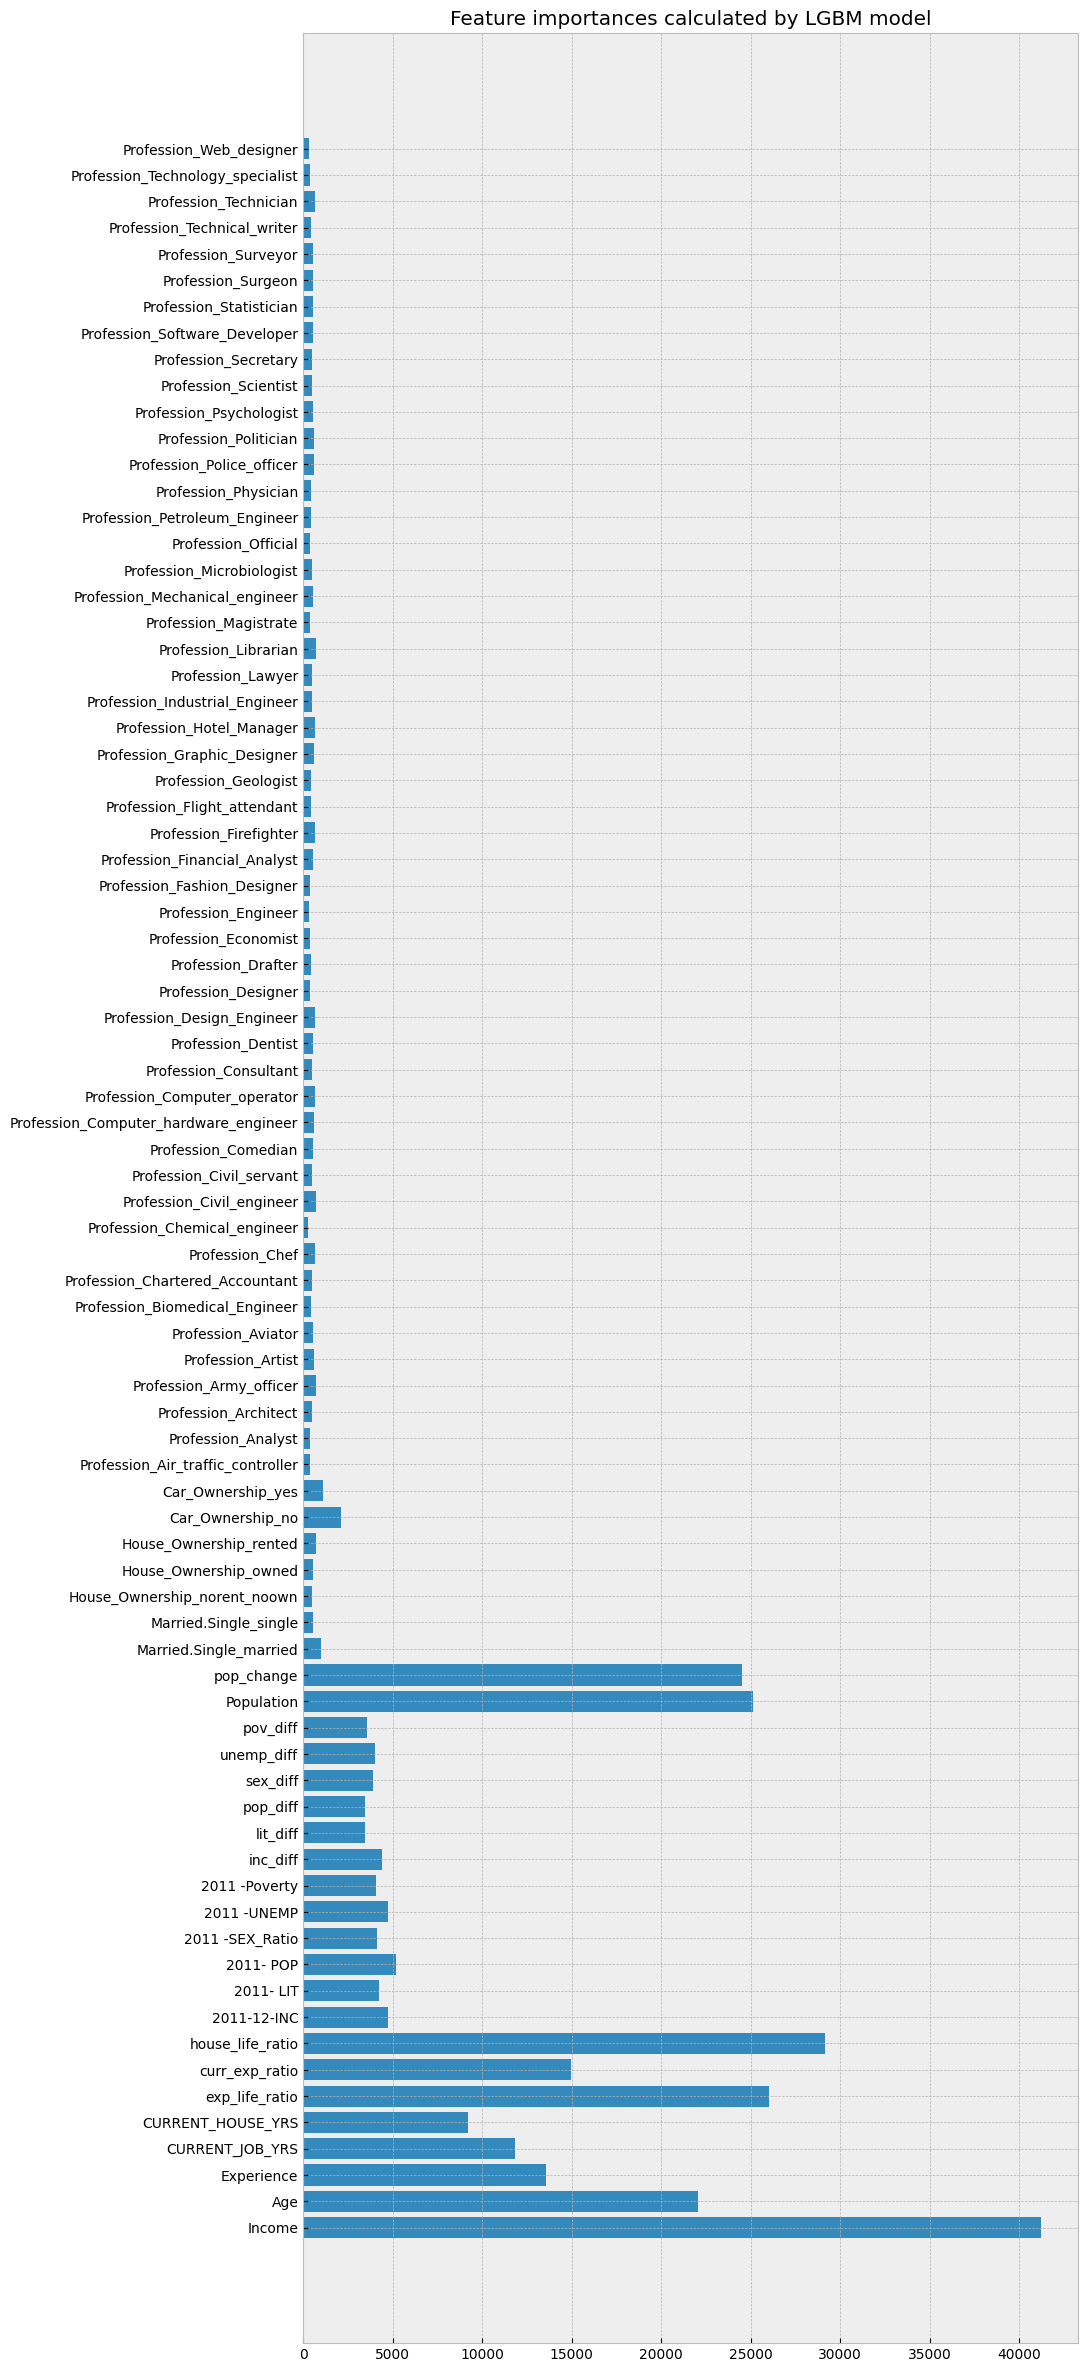

In [139]:
plt.figure(figsize=(10, 30))
plt.barh(X_train_full.columns, lgbm.feature_importances_)
plt.title('Feature importances calculated by LGBM model')
plt.show()

As we can see the most important is income - quite logical thing . Categorical data as we can see - they do not influance much into model. Also wise data from states. But as I said before - population and population change is important for model, wha is very interesting. Also ratios of Experience to life and Current house living to life are important what is making sense. maybe more stable people are less risky.

Let's take a look for confusion matrix of predictions:

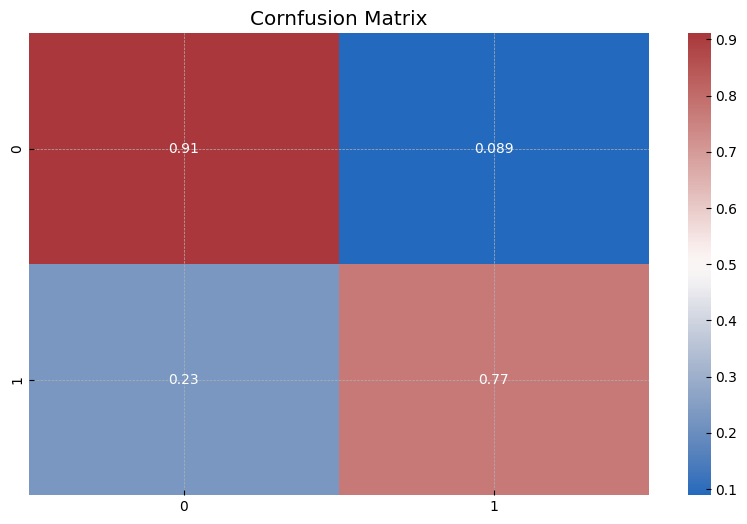

In [140]:
plt.figure(figsize=(10, 6))
plt.title('Cornfusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_lgbm, normalize='true'), annot=True, cmap='vlag')
plt.show()

As confusion matrix is showing nicely - 91% of not defaults were predicted well, and 77% of defaults. False negatives are 23% of all Positives, and just almost 9% are False positives. That means that 9% of 'right' customers will not get a loan if our model will give a decsion to give them a loan or not. Also model will make 23% of mistakes, and give loan to 'not right' people.

Let's take a look for performance changes with different propabilities.

In [141]:
preds_df = pd.DataFrame(y_test) # I'll make dataframe with propabilities given to each records, and their true values

In [142]:
preds_df.columns = ['y_true']

In [143]:
preds_df['y_proba'] = y_proba

In [144]:
preds_df # short look for dataframe

y_true   y_proba
43935        0  0.000087
115795       0  0.000002
15250        0  0.000142
97743        0  0.000162
159535       0  0.000285
...        ...       ...
20755        0  0.000589
68516        0  0.000116
84515        0  0.000777
135728       0  0.000029
114116       0  0.003089

[35726 rows x 2 columns]

In [145]:
qls = np.round(np.linspace(0.01, 1, 100), 2)

In [146]:
qls_df = pd.DataFrame(qls, columns=['probas'])

In [147]:
f_scores = []
accuracies = []
precisions = []
recalls = []
for q in qls:
    q_p = np.quantile(preds_df['y_proba'], q)
    preds_df[f'y_{q}'] = preds_df['y_proba'].apply(lambda x: 1 if x > q_p else 0)
    f_score = f1_score(preds_df['y_true'], preds_df[f'y_{q}'])
    acc = accuracy_score(preds_df['y_true'], preds_df[f'y_{q}'])
    prec = precision_score(preds_df['y_true'], preds_df[f'y_{q}'])
    rec = recall_score(preds_df['y_true'], preds_df[f'y_{q}'])
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f_scores.append(f_score)

In [148]:
qls_df['f1_scores'] = np.round(f_scores,4)
qls_df['accuracies'] = np.round(accuracies ,4)
qls_df['precisions'] = np.round(precisions,4)
qls_df['recalls'] = np.round(recalls,4)

In [149]:
qls_df = qls_df.set_index('probas')

In [150]:
qls_max = qls_df[qls_df['f1_scores'] == max(qls_df['f1_scores'])]

In [151]:
max_num = qls_max.iloc[0, 0]

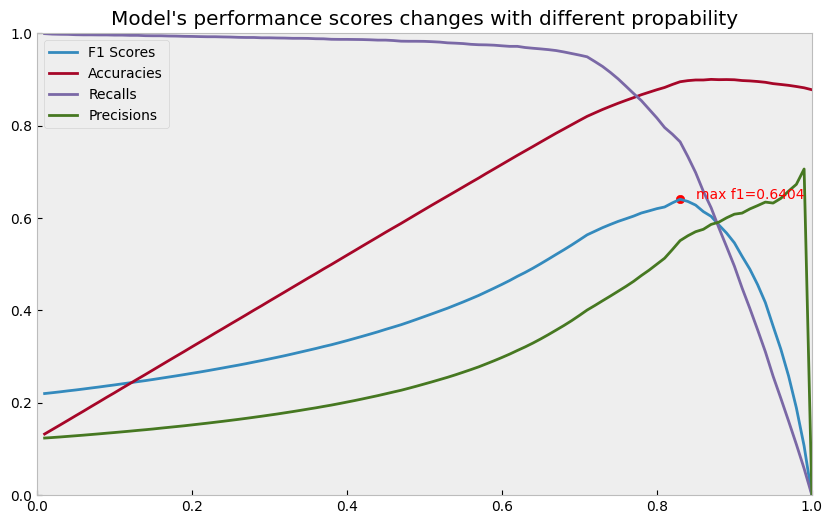

In [152]:
plt.figure(figsize=(10,6))
plt.scatter(qls_max.index, max_num, c='r')
plt.plot(qls_df.index, qls_df['f1_scores'], label='F1 Scores')
plt.plot(qls_df.index, qls_df['accuracies'], label='Accuracies')
plt.plot(qls_df.index, qls_df['recalls'], label='Recalls')
plt.plot(qls_df.index, qls_df['precisions'], label='Precisions')
plt.text(qls_max.index[0] + 0.02, max_num, f'max f1={max_num}', c='r')
plt.title("Model's performance scores changes with different propability")
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.show()

As we can see with given model we can choose between giving more risky loans and stay conservative. Until propability around 0.75 recall is higher than 90%, so 90% percent of defaults will be detected. On this point F1 score is good trade-off between being risky and conservative.

## 4. Final thoughts

As I mentionet before, f1 score with 0.64 is good trade-off. Problem with given daas is that we didn't have other informations about customers which will be valuable for predicting credit risk. Those can be:

- number of children
- loan amount
- loan monthly payment
- value and number of other loans
- amount of monthly payments
- more data details about professions
- credit history

At least even without those data, performance got well.

Thank you for attention :)